In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt 
from scipy import interpolate
import random
import math
import torch
import copy
import time

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyClassifier
from sklearn import metrics
from sklearn.svm import SVC

import torch
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
import gc
import mads_dl

from PIL import Image
from IPython.display import Image
import matplotlib.cm as cm
import seaborn as sns
torch.manual_seed(1)
from classes import *
# set all columns to be displayed
pd.set_option('display.max_columns', None)

loaddata = LoadData()


2024-11-14 18:48:22.656745: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731606502.669071  140549 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731606502.673082  140549 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 18:48:22.686068: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Classes

## Loading Data Classes

In [2]:
# 'FA_20231206_2H_yeast_Pyruvate-d3_1.ser.csv'
# 'FA_20240517_2H_yeast_Nicotinamide-d4 _9.csv'
# 'FA_20240213_2H_yeast_Fumarate-d2_9.csv
file = str(Path('FA_20231123_2H Yeast_Fumarate-d2_12 .csv'))
substrates = loaddata.get_substrate_list(file)
metabolites = loaddata.get_metabolite_list(file)
substrates = [float(i) for i in substrates]
metabolites = [float(i) for i in metabolites]
path_list = loaddata.load_data(file)

In [3]:
print(substrates, metabolites)

[6.653, 4.7] [4.368, 2.474]


# Step 1: Loading the data

In [4]:
# shapes of all the csv files
path_list2 = loaddata.load_data('.csv')

for path in path_list2:
    df = pd.read_csv(path)
    print(df.shape)

(632, 51)
(622, 236)
(806, 151)
(1063, 51)
(837, 238)
(654, 51)
(585, 236)
(960, 131)
(855, 131)
(577, 236)
(679, 151)
(1429, 131)
(1583, 131)
(1170, 236)
(966, 51)
(1527, 131)
(841, 41)
(2003, 131)
(843, 238)
(859, 236)
(706, 131)
(1226, 131)
(880, 131)
(779, 131)
(695, 131)
(778, 51)
(636, 237)
(653, 131)
(1045, 131)
(925, 71)
(793, 236)
(718, 238)
(782, 236)
(2122, 131)
(1279, 131)
(1632, 131)
(941, 238)
(537, 236)
(1796, 101)
(890, 237)
(823, 131)
(1503, 131)
(1675, 131)
(861, 151)
(681, 236)
(1147, 51)
(755, 131)
(608, 238)
(1480, 237)
(2268, 131)
(1045, 181)
(1023, 51)
(1418, 238)
(691, 236)
(735, 131)
(655, 236)
(1139, 181)
(921, 131)
(673, 236)
(645, 238)
(1074, 131)
(908, 51)
(957, 131)
(877, 40)
(1297, 131)
(951, 131)
(1594, 131)
(799, 131)
(776, 236)
(971, 237)
(1675, 131)
(1178, 237)
(2072, 131)
(898, 51)


In [5]:
for file in path_list:
    df = pd.read_csv(file)
    print(df.shape)

(2268, 131)


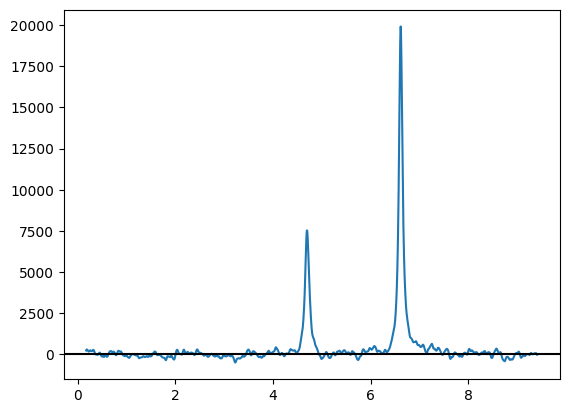

In [6]:
for i in range(len(path_list)):
    df = pd.read_csv(path_list[i])
    

    x = df.iloc[:,0]
    y = df.iloc[:, 1]

    #print(df.shape)

    plt.plot(x,y)

# show x  lines
plt.axhline(y=0, color='k')
plt.show()

# Step 2: Generating synthetic Data for - FA_20231113_2H_yeast_Pyruvate-d3_1.csv

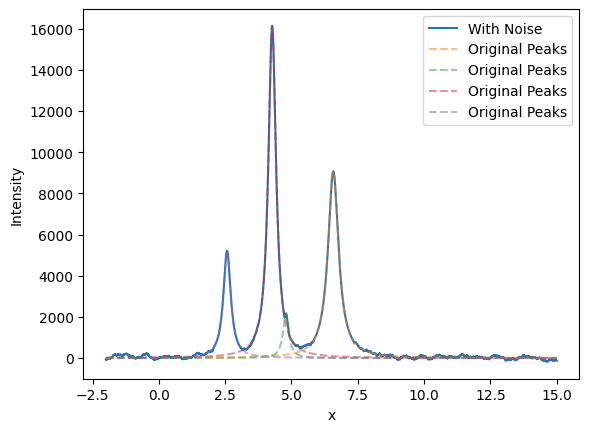

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Lorentzian function
def lorentzian(x, x0, gamma, height):
    return height * (gamma**2 / ((x - x0)**2 + gamma**2))


def generate_random_spectrum(peak_list, spectrum_length=3000):

    # Generate random spectrum with Lorentzian peaks
    x = np.linspace(-2, 15, spectrum_length)  # x range
    y = np.zeros_like(x)          # initialize y as zeros
    mask = np.zeros_like(x)       # mask to identify peak regions

    # Add random Lorentzian peaks
    x0_parms = []
    gamma_parms = []
    height_parms = []

    x0_substrate_parms = []
    gamma_substrate_parms = []
    height_substrate_parms = []

    for peak_pos in peak_list:
        metabolism_x0 = peak_pos + np.random.uniform(-0.1, 0.1)
        
        metabolism_gamma = np.random.uniform(0.01, 0.3)  # Random width (gamma)
        metabolism_height = np.random.uniform(100, df.max().max())  # Random height
        peak_lorenz = lorentzian(x, metabolism_x0, metabolism_gamma, metabolism_height)
        y = np.maximum(y, peak_lorenz)  # Use maximum to avoid summing peaks

        # Create a mask to identify regions near the peaks (exclude noise here)
        mask += peak_lorenz > (0.1 * metabolism_height)  # Masking regions where peak height is significant

        # Append the parameters for the peak
        x0_parms.append(metabolism_x0)
        gamma_parms.append(metabolism_gamma)
        height_parms.append(metabolism_height)



    # Add noise only outside the peak regions
    random_noise_level = np.random.uniform(0, df.max().max())
    gaussian_noise = np.random.normal(0, 500, 3000)
    laplace_noise = np.random.laplace(0, 500, 3000)

    # choose random between noise1 and noise2
    noise = gaussian_noise if np.random.rand() > 0.5 else laplace_noise

    #noise = np.random.normal(10, random_noise_level, spectrum_length)

    # smooth the noise with gaussian filter
    sigma = random_noise_level /1
    #noise = gaussian_filter1d(noise, sigma=sigma)
    # rollwing window mean
    noise = np.convolve(noise, np.ones(50)/50, mode='same')
    
    
        
    y_noisy = y + noise * (mask == 0)  # Add noise only where mask is 0 (outside peaks)

    return x, y_noisy, np.array(x0_parms), np.array(gamma_parms), np.array(height_parms)


# ----

#peak_list = [2.323, 4.7, 1.201]
substrates_list = substrates + metabolites
x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)

# Plot the result
plt.plot(x, y_noisy, '-', label="With Noise")

for x0, gamma, height in zip(x0_parms, gamma_parms, height_parms):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', label="Original Peaks", alpha=0.5)  
plt.xlabel('x')
plt.ylabel('Intensity')
plt.legend()
plt.show()


# Step 3: Fill Up Original Data 

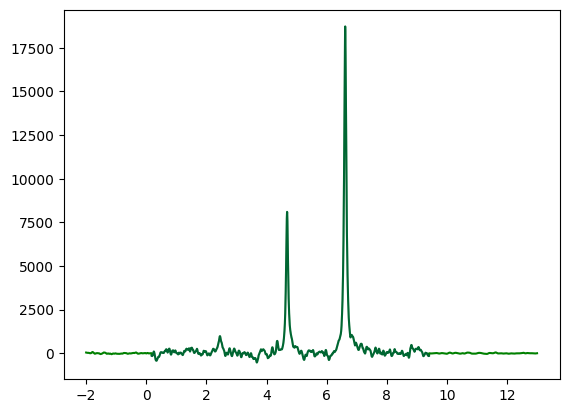

(3686, 2)


,x,y
0,-2.000000,44.408359
1,-1.995927,43.633022
2,-1.991855,42.154093
3,-1.987782,40.136399
4,-1.983710,37.777981
...,...,...
3681,12.983526,1.487833
3682,12.987599,2.264826
3683,12.991671,2.876064
3684,12.995744,3.294473


In [8]:



def interpolate_to_shape(x_original, y_original, spectrum_lenth=3000):
    """_summary_

    # Originaldaten
    y_original = df.iloc[:, 1]
    x_original = df.iloc[:, 0]

    Args:
        df (_type_): _description_
    """


    # Neue x-Werte (stellen Sie sicher, dass diese innerhalb des Bereichs von x_original liegen)
    x_new = np.linspace(x_original.min(), x_original.max(), spectrum_lenth)

    # Interpolierte Daten
    interpolated_data = interpolate.interp1d(x_original, y_original, kind='linear')(x_new)
    
    df = pd.DataFrame({'x': x_new, 'y': interpolated_data})
    return df

def fill_df(df):
    """If Data is not ranging from -2 to 10, fill the data with noise
    
    """
    # renmame the columns
    df.columns = ['x', 'y']
    x = df.loc[:, 'x']
    y = df.loc[:, 'y']



    # Calculate the step size of the x values
    x_diff = np.diff(x)
    step = np.mean(x_diff)
    
    # Take sample range for the noise
    x_range_lower = 0
    x_range_upper = 100

    # get sample data of the noise
    x_sample = x[x_range_lower:x_range_upper]
    y_sample = y[x_range_lower:x_range_upper]

    # get the max and min values of the sample data
    y_min, y_max = (y_sample.min()), abs(y_sample.max())
    #print(y_min, y_max)

    # get the min max of the x values
    x_min, x_max = x.min(), x.min()

    if x_min > -2:


        # create values in n steps
        x_new = np.arange(-2, x.iloc[0], step)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))


        
        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([data, df], axis=0)
        df.reset_index(drop=True, inplace=True)

    if x_max < 15:
    
        # create values in n steps
        x_new = np.arange(x.iloc[-1], 13, step)
        #print(x_new)
        y_new = np.zeros_like(x_new)

        # set the noise level
        noise = np.random.normal(0, y_max, len(x_new))

        # smooth the noise with gaussian filter
        # Berechne die Standardabweichung der y-Daten
        sigma = len(y_new) / 100
        noise = gaussian_filter1d(input=noise, sigma=sigma)

        # replace y_new with noise
        y_new = noise

        data = pd.DataFrame({'x': x_new, 'y': y_new})
        df = pd.concat([df, data], axis=0)
        df.reset_index(drop=True, inplace=True)
                
    return df


df_fill = df.iloc[:, [0, 2]]
#print(df_fill.head())
df_filled = fill_df(df_fill)
#print(df_filled.head())

# plot 
plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1], color='green')
plt.plot(df_fill.iloc[:, 0], df_fill.iloc[:, 1], color='blue', alpha=0.2)
plt.show()
print(df_filled.shape)
display(df_filled)

# Step 3: Bring data to same shape

(3000, 2)


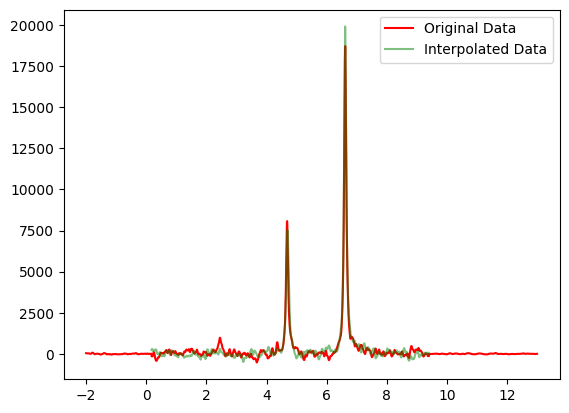

In [9]:

# Interpoliere die Werte, um die Größe des DataFrames zu erweitern
df_interpolated = interpolate_to_shape(df_filled.iloc[:, 0], df_filled.iloc[:, 1], spectrum_lenth=3000)

# Form des interpolierten DataFrames
print(df_interpolated.shape)

# Plot the interpolated data
#plt.plot(df_filled.iloc[:, 0], df_filled.iloc[:, 1])
plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], color='red',)
plt.plot(df.iloc[:, 0], df.iloc[:, 1], color='green', alpha=0.5)
plt.legend(['Original Data', 'Interpolated Data', 'Sum'])
plt.show()

# Step 4: Bring Data to shape for Transformer

In [10]:
df_interpolated.shape

(3000, 2)

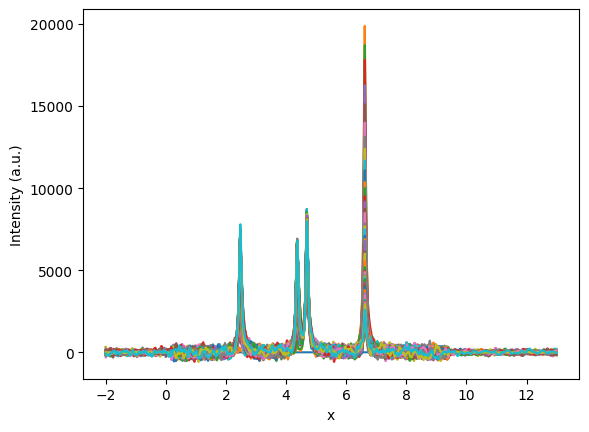

In [11]:
for i in range(df.shape[1]-1):

    df_filled = fill_df(df.iloc[:, [0, i]])
    df_interpolated = interpolate_to_shape(df_filled.loc[:,'x'], df_filled.loc[:,'y'], spectrum_lenth=3000)
    #plt.plot(df_filled.loc[:,'x'], df_filled.loc[:,'y'], '-', label='Original Data')
    plt.plot(df_interpolated.iloc[:, 0], df_interpolated.iloc[:, 1], '-', label='Interpolated Data')

# data_train_tensor & y_train
substrates_list = substrates + metabolites
x_synth, y_synth, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)


#plt.plot(x_synth, y_synth, label="With Noise")
plt.xlabel('x')
plt.ylabel('Intensity (a.u.)')

plt.show()

# Generate training Dataset 

In [12]:

num_samples = 5000

x_data = []
y_data = []
x0_parms_list = []
gamma_parms_list = []
height_parms_list = []
for i in range(num_samples):
    # data_train_tensor & y_train
    substrates_list = substrates + metabolites
    x, y_noisy, x0_parms, gamma_parms, height_parms = generate_random_spectrum(substrates_list)
    x_data.append(x)
    y_data.append(y_noisy)
    x0_parms_list.append(x0_parms)
    gamma_parms_list.append(gamma_parms)
    height_parms_list.append(height_parms)




# Umwandeln der lists in Tensoren
x_data = torch.tensor(x_data)
data = torch.tensor(y_data) # Data: Noisy Spectra which is input to the model
x_params_tensor = torch.tensor(x0_parms_list) # Target: 
gamma_params_tensor = torch.tensor(gamma_parms_list)
height_params_tensor = torch.tensor(height_parms_list)

target = torch.cat((x_params_tensor, gamma_params_tensor, height_params_tensor), dim=1)



# Überprüfen der Formen
print(f"x_data shape: {x_data.shape}")
print(f"data shape: {data.shape}")
print(f"x_params_tensor shape: {x_params_tensor.shape}")
print(f"gamma_params_tensor shape: {gamma_params_tensor.shape}")
print(f"height_params_tensor shape: {height_params_tensor.shape}")
print(f"target shape: {target.shape}")
print('\n')

x_data shape: torch.Size([5000, 3000])
data shape: torch.Size([5000, 3000])
x_params_tensor shape: torch.Size([5000, 4])
gamma_params_tensor shape: torch.Size([5000, 4])
height_params_tensor shape: torch.Size([5000, 4])
target shape: torch.Size([5000, 12])




/tmp/ipykernel_140549/809751612.py:22: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  x_data = torch.tensor(x_data)


In [13]:

def scale_data(data, target):
    """Scale the data
    
    Args:
        x_data (_type_): _description_
        y_data (_type_): _description_
    """
    # Skalieren Sie die Daten
    data_scaler = MinMaxScaler()
    target_scaler = MinMaxScaler()

    print(f'Before Scaling: {data.shape}')
    print(f'Before Scaling: {target.shape}')

    # Reshape the data before scaling
    data = data.reshape(data.shape[0], -1)
    target = target.reshape(target.shape[0], -1)

    print(f'After Reshaping: {data.shape}')
    print(f'After Reshaping: {target.shape}')

    # Skalieren Sie die x-Daten
    data_scaled = data_scaler.fit_transform(data)
    target_scaled = target_scaler.fit_transform(target)
    
    print(f'After Scaling: {data_scaled.shape}')
    print(f'After Scaling: {target_scaled.shape}')


    return data_scaled, target_scaled, data_scaler, target_scaler
    

# Skalieren Sie die Daten
data_scaled, target_scaled, data_scaler, target_scaler = scale_data(data, target)

Before Scaling: torch.Size([5000, 3000])
Before Scaling: torch.Size([5000, 12])
After Reshaping: torch.Size([5000, 3000])
After Reshaping: torch.Size([5000, 12])
After Scaling: (5000, 3000)
After Scaling: (5000, 12)


In [14]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



# Aufteilen der Daten in Trainings- und Testsets
data_train, data_tmp, target_train, target_tmp = train_test_split(data, target, 
                                                    test_size=0.4,
                                                    shuffle=True,
                                                    random_state=1)
data_val, data_test, target_val, target_test = train_test_split(data_tmp, target_tmp,
                                                    test_size=0.5,
                                                    shuffle=True,
                                                    random_state=1)

# import StandardScaler
from sklearn.preprocessing import StandardScaler

# Skalieren der Daten
data_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

# Skalieren von data train und test
data_train_sc = data_scaler.fit_transform(data_train)
data_val_sc = data_scaler.transform(data_val)
data_test_sc = data_scaler.transform(data_test)

# Skalieren von target train und test
target_train_sc = target_scaler.fit_transform(target_train)
target_val_sc = target_scaler.transform(target_val)
target_test_sc = target_scaler.transform(target_test)


# Konvertieren in Tensoren
data_train_tensor = torch.tensor(data_train_sc, dtype=torch.float32)
data_val_tensor = torch.tensor(data_val_sc, dtype=torch.float32)
data_test_tensor = torch.tensor(data_test_sc, dtype=torch.float32)
target_train_tensor = torch.tensor(target_train_sc, dtype=torch.float32)
target_val_tensor = torch.tensor(target_val_sc, dtype=torch.float32)
target_test_tensor = torch.tensor(target_test_sc, dtype=torch.float32)





# # Reshape the tensors for the model
# target_train_tensor = target_train_tensor.reshape(target_train_tensor.shape[0], -1)
# target_val_tensor = target_val_tensor.reshape(target_val_tensor.shape[0], -1)

# Überprüfen der Tensoren
print(f"Data Train Shape: {data_train_tensor.shape}")
print(f"Data Val Shape: {data_val_tensor.shape}")
print(f"Data Test Shape: {data_test_tensor.shape}")
print(f"Target Train Shape: {target_train_tensor.shape}")
print(f"Target Val Shape: {target_val_tensor.shape}")
print(f"Target Test Shape: {target_test_tensor.shape}")

Data Train Shape: torch.Size([3000, 3000])
Data Val Shape: torch.Size([1000, 3000])
Data Test Shape: torch.Size([1000, 3000])
Target Train Shape: torch.Size([3000, 12])
Target Val Shape: torch.Size([1000, 12])
Target Test Shape: torch.Size([1000, 12])


# LSTM 

In [15]:
# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()

#         self.reduce = nn.Linear(3000, hidden_size)

#         # Define LSTM with correct hidden size
#         self.lstm = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True)

#         # Fully connected layers with corrected input sizes
#         self.fc1 = nn.Sequential(
#             nn.Linear(hidden_size, 128),  # Match hidden_size with the output of LSTM
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(128, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(32, 16),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(16, output_size)

#     def forward(self, x):
#         # Check shape before reducing
#         #print(f"Input shape before reduction: {x.shape}")  # For debugging
#         x = self.reduce(x)  # This should expect (batch_size, 3000)
        

#         # Reshape for LSTM input
#         x = x.reshape(x.shape[0], 1, -1)  # Reshape to (batch_size, seq_len, input_size)
#         #print(f"Shape after reduction: {x.shape}")

#         batch_size = x.shape[0]
        
#         # Initialize hidden and cell states with hidden_size instead of input_size
#         h_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)
#         #c_0 = torch.zeros(2, batch_size, hidden_size).to(x.device)

#         # Pass data through LSTM
#         x, _ = self.lstm(x, (h_0))
#         x = x[:, -1, :]  # Take the output from the last time step

#         # Pass data through fully connected layers
#         x = self.fc1(x)
#         x = self.fc2(x)
#         x = self.fc3(x)

#         # Final output
#         output = self.output(x)
#         return output
    
#     def predict(self, X):
#         '''
#         Use the model to predict for the values in the test set.
#         Return the prediction
#         '''
#         model.eval()
#         with torch.no_grad():
#             return model(X)


In [16]:
print(data_train_tensor.shape, target_train_tensor.shape)

torch.Size([3000, 3000]) torch.Size([3000, 12])


# Conv1D

In [17]:
# import torch
# import torch.nn as nn

# class NeuralNetwork(nn.Module):
#     def __init__(self, input_size, hidden_size, output_size, dropout_prob):
#         super(NeuralNetwork, self).__init__()
        
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=2, stride=2, padding=0),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )
#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        
        
#         self.conv2 = nn.Sequential(
#             nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=1, padding=1),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
        

#         # Fully connected layers
#         self.fc1 = nn.Sequential(
#             nn.Linear(3000, 1000),  # Adjust for pooling effects
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc2 = nn.Sequential(
#             nn.Linear(1000, 128),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         self.fc3 = nn.Sequential(
#             nn.Linear(3000, 32),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(32, output_size)

#     def forward(self, x):
#         # Apply convolutional layers with pooling
        
#         x = x.unsqueeze(1)
#         x = self.firstpooling(x)
#         x = self.conv1(x)      
#         x = self.conv2(x)  

#         #print(x.shape)
#         # Flatten the output for fully connected layers
#         x = x.reshape(x.shape[0], -1)        
#         # Pass through fully connected layers
#         # x = self.fc1(x)
#         # x = self.fc2(x)
#         x = self.fc3(x)

#         # Output layer
#         output = self.output(x)
#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)


In [18]:
# import torch
# import torch.nn as nn
# import math

# class NeuralNetwork(nn.Module):
#     def __init__(self, 
#                  input_size=3000, 
#                  hidden_size=128, 
#                  output_size=27, 
#                  dropout_prob=0.2,
#                  avgpool_kernel_size=2,
#                  avgpool_stride=2,
#                  avgpool_padding=0,

#                  conv1_in_channels=1,
#                  conv1_out_channels=8,
#                  conv1_kernel_size=3,
#                  conv1_stride=1,
#                  conv1_padding=1,

#                  conv2_in_channels=8,
#                  conv2_out_channels=12,
#                  conv2_kernel_size=3,
#                  conv2_stride=1,
#                  conv2_padding=1,
#                  fc1_out_features=128,
                
#                  fc3_out_features=32):
#         super(NeuralNetwork, self).__init__()
        
#         # Pooling and activation
#         self.firstpooling = nn.Sequential(
#             nn.AvgPool1d(kernel_size=avgpool_kernel_size, stride=avgpool_stride, padding=avgpool_padding),
#             nn.Dropout(p=dropout_prob),
#             nn.LeakyReLU()
#         )

#         # Convolutional and pooling layers  
#         self.conv1 = nn.Sequential(
#             nn.Conv1d(in_channels=conv1_in_channels, out_channels=conv1_out_channels, 
#                       kernel_size=conv1_kernel_size, stride=conv1_stride, padding=conv1_padding),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )

#         # self.conv2 = nn.Sequential(
#         #     nn.Conv1d(in_channels=conv1_out_channels, out_channels=conv2_out_channels, 
#         #               kernel_size=conv2_kernel_size, stride=conv2_stride, padding=conv2_padding),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob),
#         #     nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         # )

#         # Compute output size after convolution and pooling
#         def compute_output_size(input_len, kernel_size, stride, padding, layers=1):
#             for _ in range(layers):
#                 input_len = math.floor((input_len + 2 * padding - (kernel_size - 1) - 1) / stride + 1)
#             return input_len

#         pooled_size = compute_output_size(input_size, avgpool_kernel_size, avgpool_stride, avgpool_padding)
#         conv1_size = compute_output_size(pooled_size, conv1_kernel_size, conv1_stride, conv1_padding)
#         conv1_pooled = math.floor(conv1_size / 2)  # Max pooling halves the size
#         conv2_size = compute_output_size(conv1_pooled, conv2_kernel_size, conv2_stride, conv2_padding)
#         conv2_pooled = math.floor(conv2_size / 2)  # Max pooling halves the size again

#         flattened_size = conv1_out_channels * conv1_pooled

#         # # Fully connected layers
#         # self.fc1 = nn.Sequential(
#         #     nn.Linear(flattened_size, fc1_out_features),
#         #     nn.LeakyReLU(),
#         #     nn.Dropout(p=dropout_prob)
#         # )

#         self.fc2 = nn.Sequential(
#             nn.Linear(flattened_size, fc3_out_features),
#             nn.LeakyReLU(),
#             nn.Dropout(p=dropout_prob)
#         )

#         # Output layer
#         self.output = nn.Linear(fc3_out_features, output_size)

#     def forward(self, x):
#         x = x.unsqueeze(1)  # Add channel dimension
#         x = self.firstpooling(x)
#         x = self.conv1(x)
#         #x = self.conv2(x)
#         x = x.reshape(x.shape[0], -1)  # Flatten
#         #x = self.fc1(x)
#         x = self.fc2(x)
#         output = self.output(x)

#         return output

#     def predict(self, X):
#         self.eval()
#         with torch.no_grad():
#             return self(X)

# Linear Layer

In [19]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, 
                 input_size=3000, 
                 fc1_output=512, 
                 output_size=len(substrates_list) * 3, 
                 dropout_prob=0.1,
                 kernel_size=2,
                 stride=1,
                 padding=1
                 ):
        

        super(NeuralNetwork, self).__init__()

        self.pooling = nn.Sequential(
            nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=padding)
        )
        reduced_size = (input_size + 2 * padding - kernel_size) // stride + 1
        self.fc1 = nn.Sequential(
            nn.Linear(reduced_size, fc1_output),
            nn.LeakyReLU(),
            nn.Dropout(p=dropout_prob)
        )


        # Output layer
        self.output = nn.Linear(fc1_output, output_size)

    def forward(self, x):
        x = self.pooling(x)

        x = self.fc1(x)
        output = self.output(x)
        return output

    def predict(self, X):
        self.eval()
        with torch.no_grad():
            return self(X)

# Training

In [20]:

def calculate_mse_of_real_data(df, model, random=True, i = 3, tensor=False):

    """
    e.g. df: df.iloc[:, [0, 1]]
    """

    if random:
        i = np.random.randint(1, df.shape[1])

    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32).to(device)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    if tensor == True:
        print(target_real_pred)

    # bring the data back to the cpu
    target_real_pred_cpu = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred_cpu)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

        

    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)

    # calculate the mse between the real data and lorentz_df
    mse = mean_squared_error(y_real, lorentz_df['max'])
    return mse

In [21]:
def calculate_mse_of_real_data_loss(df, model, random=True, i=3, device='cpu'):
    """
    Calculate MSE of real data, ensuring it can be used for backpropagation.
    """
    if random:
        i = np.random.randint(1, df.shape[1])

    # Fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # Interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    x_real = torch.tensor(df_interpolated['x'].values, dtype=torch.float32, device=device, requires_grad=False)
    y_real = torch.tensor(df_interpolated['y'].values, dtype=torch.float32, device=device, requires_grad=False)

    # scale the data
    y_real_sc = data_scaler.transform(y_real.cpu().numpy().reshape(1, -1))
    


    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32, requires_grad=True).to(device)

    # Predict the data
    target_real_pred = model(y_real_tensor)

    # reshape the data
    target_real_pred = target_real_pred.reshape(target_real_pred.shape[0], -1)
    #print(target_real_pred.shape)


    # # Split the predictions
    x0_parms_real, gamma_parms_real, height_parms_real = torch.split(
        target_real_pred, target_real_pred.shape[1] // 3, dim=1
    )
    #print(x0_parms_real.shape)
    # Compute Lorentzian functions
    lorentz_list = []
    for x0, gamma, height in zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0]):
        lorentz = lorentzian(x_real, x0, gamma, height)  # Assume lorentzian returns a PyTorch tensor
        lorentz_list.append(lorentz)

    lorentz_tensor = torch.stack(lorentz_list, dim=1)
    max_lorentz = torch.max(lorentz_tensor, dim=1).values

    # del lorentz_tensor, x0_parms_real, gamma_parms_real, height_parms_real, target_real_pred, y_real_tensor
    # torch.cuda.empty_cache()


    # Compute MSE using PyTorch
    mse = torch.nn.functional.mse_loss(max_lorentz, y_real)
    
    # if True:
    #     # Convert to NumPy for plotting
    #     tensor_1d_np = max_lorentz.detach().cpu().numpy()

    #     # Plot
    #     plt.plot(x_real,tensor_1d_np)
    #     plt.title("1D Tensor Line Plot")
    #     plt.xlabel("Index")
    #     plt.ylabel("Value")
    #     plt.show()
    return mse




In [22]:


# ------------------------------------
import torch

def get_model_size(model):
    total_params = sum(p.numel() for p in model.parameters())
    size_in_bytes = total_params * 4  # Assuming 32-bit (4 bytes) floats
    size_in_megabytes = size_in_bytes / (1024 ** 2)  # Convert to MB
    return total_params, size_in_megabytes


df = pd.read_csv(path_list[0]) 

dropout_results = [] # storing the results of the dropout experiment
optuna_results = [] # storing the results of the optuna experiment

def training(model, X_train, y_train, X_val, y_val, criterion, optimizer, epochs, writer, batch_size=64, patience=20, dropout_prob=0.5, log_tensorboard=True, verbose=True, check_real_data=False):

    # Set device to GPU if available
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        device = torch.device('cpu')

   # device = torch.device('cpu')

    # Move data and model to device
    X_train, y_train, X_val, y_val = X_train.to(device), y_train.to(device), X_val.to(device), y_val.to(device)
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = float('inf') # Initialize the best_eval_metric
    best_val_loss = float('inf') # Initialize the best_val_loss
    best_real_metric_val = float('inf')
    best_train_loss = float('inf')
    best_model = copy.deepcopy(model.state_dict()) # Initialize the best_model
    patience_counter_loss = 0  # Early stopping counter
    patience_counter_metric = 0  # Early stopping counter

    # DataLoader for batching
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)


    # Scheduler for learning rate adjustment (if val_loss does not improve for 'patience' epochs)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)
    train_losses, val_losses = [], [] # to visualize the drop_out_prob
    train_accuracies, val_accuracies = [], []
    real_accuracies = []
    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)

            
            
            #print(data.shape, target.shape)
            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            #loss = criterion(outputs.squeeze(1), target)  # Calculate loss

            # FOR LSTM
            loss = criterion(outputs, target)  # Calculate loss # For LSTM
            #print(loss)
            loss_real = calculate_mse_of_real_data_loss(df, model, random=True, device=device)
            
            loss_real.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss_real # Accumulate batch loss

        # Validation
        model.eval()
        with torch.no_grad():
            
            val_outputs = model(X_val)  # Forward pass
            #loss_val = criterion(val_outputs.squeeze(1), y_val)
            # FOR LSTM
            loss_val = criterion(val_outputs, y_val)
            scheduler.step(loss_val)  # Adjust learning rate based on loss
            
            # calculate the training mase
            predictions_train = model.predict(X_train)
            
            mse_train = mean_squared_error(y_train.cpu(), predictions_train.cpu().squeeze(1))

            # Calculate validation mase
            predictions_val = model.predict(X_val)
            mse_val = mean_squared_error(y_val.cpu(), predictions_val.cpu().squeeze(1))

            # Calculate the mse of real data
            mse_real = calculate_mse_of_real_data(df, model, random=True)


            # Log to TensorBoard
            if log_tensorboard:
                writer.add_scalars("Loss", {"train": epoch_loss / len(train_loader)}, epoch)
                writer.add_scalars("MSE", {"train": mse_train, "val": mse_val}, epoch)
                writer.add_scalars("MSE/Real Data", {"MSE": mse_real}, epoch)
                writer.flush()
            
            loss_train = epoch_loss / len(train_loader)

            if loss_train < best_train_loss:
                best_train_loss = loss_train
                patience_counter_loss = 0
            else:
                patience_counter_loss += 1

            # # Early stopping if loss_val is increasing
            # if loss_val < best_val_loss:
            #     best_val_loss = loss_val  # Update best val_loss
            #     patience_counter_loss = 0  # Reset patience counter
            # else:
            #     patience_counter_loss += 1  # Increment if no improvement

            # Early Stopping based on if val_mse is not increasing
            if mse_val < best_eval_metric_val:
                best_eval_metric_val = mse_val
                #best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
                patience_counter_metric_val = 0  # Reset patience counter if improved
            else:
                patience_counter_metric_val += 1

            # early stopping if real_mse is increasing
            if mse_real < best_real_metric_val:
                best_real_metric_val = mse_real
                best_model = copy.deepcopy(model.state_dict()) # saves the best model where the rmse_val is highest
            else:
                patience_counter_metric += 1

            if check_real_data:
                train_losses.append(epoch_loss / len(train_loader))
                val_losses.append(loss_val)
                train_accuracies.append(mse_train)
                val_accuracies.append(mse_val)
                real_accuracies.append(mse_real)



            # Early stopping check
            if (patience_counter_loss >= patience):
                print(f"Early stopping at epoch {epoch+1}")
                break


        # Print status
        if verbose:
          if epoch % 19 == 0:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_loader):.4f}, Validation Loss: {loss_val:.4f} | Train MSE: {mse_train:.4f}, Val MSE: {mse_val:.4f} |")



        
    optuna_results.append({'dropout_prob': dropout_prob,
                            'train_loss': min(train_losses),
                            'val_loss': min(val_losses),
                            'training_MSE': min(train_accuracies),
                            'validation_MSE': min(val_accuracies),
                            'real_data_MSE': mse_real
                            })

            


    dropout_results.append({'dropout_prob': dropout_prob,
                                    'train_loss': train_losses,
                                    'val_loss': val_losses,
                                    'training_MSE': train_accuracies,
                                    'validation_MSE': val_accuracies
                                    })
    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation MSE: {best_eval_metric_val:.4f}")
    if check_real_data:
        print(f'MSE Real Data: {mse_real}')

    writer.close()
    # del loss_real
    # torch.cuda.empty_cache()
    # gc.collect()
    # torch.cuda.empty_cache()
    return model, optuna_results




#%tensorboard --logdir=runs


# Data preparation: ensure data shapes are correct
data_train_tensor = data_train_tensor.reshape(-1, 3000)  # Assuming original shape is (num_samples, 3000)
data_val_tensor = data_val_tensor.reshape(-1, 3000)

# Check shapes before training
print("Train shape:", data_train_tensor.shape)
print("Validation shape:", data_val_tensor.shape)

#Define model with correct input size
# input_size = 3000
# hidden_size = 512
# output_size = len(substrates_list) * 3
# dropout_prob = 0.1
# learning_rate = 0.01
# epochs = 100

# model = NeuralNetwork().to(device)
# model_size, model_size_mb = get_model_size(model)
# print(f'Total parameters: {model_size}')
# print(f'Model size: {model_size_mb:.2f} MB')

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# criterion = torch.nn.MSELoss()

# writer = SummaryWriter()

# trained_model, _ = training(model=model,
#                          X_train=data_train_tensor,
#                          y_train=target_train_tensor,
#                          X_val=data_val_tensor,
#                          y_val=target_val_tensor,
#                          criterion=criterion,
#                          optimizer=optimizer,
#                          epochs=epochs,
#                          writer=writer,
#                          dropout_prob=dropout_prob,
#                          log_tensorboard=True,
#                          verbose=True,
#                          check_real_data=True)


Train shape: torch.Size([3000, 3000])
Validation shape: torch.Size([1000, 3000])


In [23]:
df = pd.read_csv(path_list[0]) 



# Optuna


In [24]:
import optuna
import gc

def objective(trial):
    # Suggest hyperparameters
    dropout_prob = trial.suggest_float('dropout_prob', 0.1, 0.99, step=0.01)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 0.1, log=True)
    batch_size = trial.suggest_int('batch_size', 4, 128, step=4)
    fc1_output = trial.suggest_int('fc1_output', 1, 3000, step=1)

    kernel_size = trial.suggest_int('kernel_size',20, 150, step=1)
    stride = trial.suggest_int('stride',1, 10, step=1)
    padding = trial.suggest_int('padding',1, 10, step=1)
    
    # Initialize model and optimizer
    model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob,
        kernel_size=kernel_size,
        stride=stride,
        padding = padding
    ).to(device)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = torch.nn.MSELoss()
    writer = SummaryWriter(log_dir=f"runs/trial_{trial.number}")
    
    try:
        # Train the model
        trained_model, optuna_results = training(
            model=model,
            X_train=data_train_tensor,
            y_train=target_train_tensor,
            X_val=data_val_tensor,
            y_val=target_val_tensor,
            criterion=criterion,
            optimizer=optimizer,
            epochs=1000,
            writer=writer,
            dropout_prob=dropout_prob,
            log_tensorboard=True,
            verbose=False,
            check_real_data=True,
            batch_size=batch_size
        )
        
        mse_val = optuna_results[-1]['train_loss']



        
    finally:
        # Cleanup
        writer.close()
        del model, optimizer
        torch.cuda.empty_cache()
        gc.collect()
        torch.cuda.empty_cache()  # Free unused memory
        #torch.cuda.synchronize()  # Ensure all computations are finished

    
    return mse_val


study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)  # Run for 20 trials (adjust as needed)


/home/generalpegasus/Documents/VirtualEnvirnoments/.main/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2024-11-14 18:48:42,642] A new study created in memory with name: no-name-e4e13c80-dda3-4f5c-a5d5-bb40dd731ad6
[I 2024-11-14 18:49:00,067] Trial 0 finished with value: 776875.4375 and parameters: {'dropout_prob': 0.43000000000000005, 'learning_rate': 0.0012489013453341764, 'batch_size': 48, 'fc1_output': 1443, 'kernel_size': 100, 'stride': 10, 'padding': 1}. Best is trial 0 with value: 776875.4375.


Early stopping at epoch 50
Best validation MSE: 6814.8804
MSE Real Data: 21183063400807.87


[I 2024-11-14 18:49:09,232] Trial 1 finished with value: 844625.6875 and parameters: {'dropout_prob': 0.7, 'learning_rate': 0.07413266503818766, 'batch_size': 92, 'fc1_output': 2660, 'kernel_size': 125, 'stride': 2, 'padding': 10}. Best is trial 0 with value: 776875.4375.


Early stopping at epoch 45
Best validation MSE: 471821216.0000
MSE Real Data: 8955976.779484767


[I 2024-11-14 18:49:16,798] Trial 2 finished with value: 773325.4375 and parameters: {'dropout_prob': 0.72, 'learning_rate': 0.0013234168462747968, 'batch_size': 124, 'fc1_output': 172, 'kernel_size': 58, 'stride': 5, 'padding': 2}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 52
Best validation MSE: 11.8184
MSE Real Data: 24063948541802.133


[I 2024-11-14 18:49:43,951] Trial 3 finished with value: 785563.8125 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.007536046546215285, 'batch_size': 44, 'fc1_output': 2896, 'kernel_size': 130, 'stride': 2, 'padding': 1}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 71
Best validation MSE: 25535.8613
MSE Real Data: 25932274916955.55


[I 2024-11-14 18:49:49,088] Trial 4 finished with value: 796391.9375 and parameters: {'dropout_prob': 0.85, 'learning_rate': 0.0012285969346331014, 'batch_size': 84, 'fc1_output': 507, 'kernel_size': 37, 'stride': 9, 'padding': 7}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 25
Best validation MSE: 18.9075
MSE Real Data: 16993628660063.928


[I 2024-11-14 18:49:59,040] Trial 5 finished with value: 787376.6875 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.0018455509877947534, 'batch_size': 68, 'fc1_output': 1630, 'kernel_size': 66, 'stride': 3, 'padding': 8}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 39
Best validation MSE: 8331.4512
MSE Real Data: 21257052552078.355


[I 2024-11-14 18:50:11,883] Trial 6 finished with value: 798026.0625 and parameters: {'dropout_prob': 0.91, 'learning_rate': 0.009023563313120087, 'batch_size': 56, 'fc1_output': 1266, 'kernel_size': 40, 'stride': 6, 'padding': 1}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 43
Best validation MSE: 18453.0176
MSE Real Data: 15432526897341.178


[I 2024-11-14 18:51:27,007] Trial 7 finished with value: 810271.8125 and parameters: {'dropout_prob': 0.54, 'learning_rate': 0.018201087594240783, 'batch_size': 8, 'fc1_output': 1420, 'kernel_size': 28, 'stride': 5, 'padding': 9}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 41
Best validation MSE: 1777039.1250
MSE Real Data: 63465384377196.35


[I 2024-11-14 18:51:33,548] Trial 8 finished with value: 781535.3125 and parameters: {'dropout_prob': 0.75, 'learning_rate': 0.00929709096800881, 'batch_size': 76, 'fc1_output': 657, 'kernel_size': 85, 'stride': 9, 'padding': 10}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 29
Best validation MSE: 9567.9902
MSE Real Data: 21550253983957.043


[I 2024-11-14 18:51:39,848] Trial 9 finished with value: 777060.625 and parameters: {'dropout_prob': 0.53, 'learning_rate': 0.007913700928049945, 'batch_size': 76, 'fc1_output': 1418, 'kernel_size': 62, 'stride': 8, 'padding': 10}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 28
Best validation MSE: 10645.9492
MSE Real Data: 23927160323290.566


[I 2024-11-14 18:51:43,084] Trial 10 finished with value: 820154.625 and parameters: {'dropout_prob': 0.99, 'learning_rate': 0.00010801805256418745, 'batch_size': 128, 'fc1_output': 69, 'kernel_size': 99, 'stride': 5, 'padding': 3}. Best is trial 2 with value: 773325.4375.


Early stopping at epoch 22
Best validation MSE: 0.2904
MSE Real Data: 1641368.3883576766


[I 2024-11-14 18:51:52,408] Trial 11 finished with value: 732998.5625 and parameters: {'dropout_prob': 0.36, 'learning_rate': 0.0003866155120183047, 'batch_size': 128, 'fc1_output': 1972, 'kernel_size': 103, 'stride': 7, 'padding': 4}. Best is trial 11 with value: 732998.5625.


Early stopping at epoch 65
Best validation MSE: 18.2767
MSE Real Data: 7315198787253.784


[I 2024-11-14 18:51:57,901] Trial 12 finished with value: 735490.625 and parameters: {'dropout_prob': 0.37, 'learning_rate': 0.0002942119600409847, 'batch_size': 128, 'fc1_output': 2132, 'kernel_size': 150, 'stride': 7, 'padding': 4}. Best is trial 11 with value: 732998.5625.


Early stopping at epoch 37
Best validation MSE: 14.2241
MSE Real Data: 4577940549126.205


[I 2024-11-14 18:52:04,021] Trial 13 finished with value: 763476.6875 and parameters: {'dropout_prob': 0.36, 'learning_rate': 0.00019573054251543858, 'batch_size': 108, 'fc1_output': 2192, 'kernel_size': 149, 'stride': 7, 'padding': 5}. Best is trial 11 with value: 732998.5625.


Early stopping at epoch 35
Best validation MSE: 6.1520
MSE Real Data: 3136789886741.5273


[I 2024-11-14 18:52:14,025] Trial 14 finished with value: 715189.875 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0003938565447686736, 'batch_size': 104, 'fc1_output': 2123, 'kernel_size': 149, 'stride': 7, 'padding': 4}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 59
Best validation MSE: 79.6994
MSE Real Data: 8711668394883.183


[I 2024-11-14 18:52:21,002] Trial 15 finished with value: 719083.8125 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0005116222611038683, 'batch_size': 104, 'fc1_output': 2080, 'kernel_size': 118, 'stride': 7, 'padding': 6}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 40
Best validation MSE: 78.9290
MSE Real Data: 8633952841744.876


[I 2024-11-14 18:52:28,953] Trial 16 finished with value: 734324.1875 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.000506580177305502, 'batch_size': 104, 'fc1_output': 2582, 'kernel_size': 124, 'stride': 4, 'padding': 6}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 45
Best validation MSE: 413.8795
MSE Real Data: 10068739784084.646


[I 2024-11-14 18:52:35,006] Trial 17 finished with value: 767205.4375 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0007426450820902721, 'batch_size': 104, 'fc1_output': 1818, 'kernel_size': 136, 'stride': 8, 'padding': 6}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 33
Best validation MSE: 194.1775
MSE Real Data: 17347848351499.525


[I 2024-11-14 18:52:55,783] Trial 18 finished with value: 801547.3125 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.00298547139912482, 'batch_size': 20, 'fc1_output': 2370, 'kernel_size': 113, 'stride': 6, 'padding': 5}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 27
Best validation MSE: 10945.9873
MSE Real Data: 23589742776321.426


[I 2024-11-14 18:53:08,431] Trial 19 finished with value: 800028.9375 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.00011976214984145865, 'batch_size': 96, 'fc1_output': 1066, 'kernel_size': 139, 'stride': 10, 'padding': 7}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 68
Best validation MSE: 1.0395
MSE Real Data: 1069721550797.4456


[I 2024-11-14 18:53:15,448] Trial 20 finished with value: 748704.875 and parameters: {'dropout_prob': 0.28, 'learning_rate': 0.0006700558771772829, 'batch_size': 112, 'fc1_output': 1801, 'kernel_size': 116, 'stride': 8, 'padding': 3}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 43
Best validation MSE: 146.8316
MSE Real Data: 8630748498260.176


[I 2024-11-14 18:53:24,298] Trial 21 finished with value: 745493.125 and parameters: {'dropout_prob': 0.33, 'learning_rate': 0.00030117454045370336, 'batch_size': 116, 'fc1_output': 2019, 'kernel_size': 94, 'stride': 7, 'padding': 4}. Best is trial 14 with value: 715189.875.


Early stopping at epoch 57
Best validation MSE: 18.1871
MSE Real Data: 5308572213542.817


[I 2024-11-14 18:53:36,902] Trial 22 finished with value: 713026.625 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00036429660884200525, 'batch_size': 92, 'fc1_output': 2449, 'kernel_size': 79, 'stride': 7, 'padding': 4}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 65
Best validation MSE: 96.0570
MSE Real Data: 7992052318534.996


[I 2024-11-14 18:53:42,737] Trial 23 finished with value: 730496.0 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00022044952528874425, 'batch_size': 92, 'fc1_output': 2470, 'kernel_size': 78, 'stride': 6, 'padding': 3}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 30
Best validation MSE: 27.8254
MSE Real Data: 6675407771455.852


[I 2024-11-14 18:53:52,211] Trial 24 finished with value: 735760.5625 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.0006153598922863311, 'batch_size': 96, 'fc1_output': 2957, 'kernel_size': 72, 'stride': 9, 'padding': 5}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 50
Best validation MSE: 426.7060
MSE Real Data: 7017739411444.547


[I 2024-11-14 18:53:57,536] Trial 25 finished with value: 777240.875 and parameters: {'dropout_prob': 0.45000000000000007, 'learning_rate': 0.00346181425025578, 'batch_size': 80, 'fc1_output': 2295, 'kernel_size': 111, 'stride': 4, 'padding': 7}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 24
Best validation MSE: 8952.6396
MSE Real Data: 17932647072092.83


[I 2024-11-14 18:54:06,361] Trial 26 finished with value: 755552.375 and parameters: {'dropout_prob': 0.28, 'learning_rate': 0.0001617137166275279, 'batch_size': 116, 'fc1_output': 2678, 'kernel_size': 86, 'stride': 8, 'padding': 6}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 54
Best validation MSE: 5.2621
MSE Real Data: 2841189671629.3975


[I 2024-11-14 18:54:18,309] Trial 27 finished with value: 778586.5625 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.00039633830208385564, 'batch_size': 64, 'fc1_output': 1756, 'kernel_size': 139, 'stride': 1, 'padding': 4}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 43
Best validation MSE: 6608.8433
MSE Real Data: 21656888117290.203


[I 2024-11-14 18:54:24,782] Trial 28 finished with value: 778325.875 and parameters: {'dropout_prob': 0.63, 'learning_rate': 0.000865696066762896, 'batch_size': 88, 'fc1_output': 1991, 'kernel_size': 52, 'stride': 7, 'padding': 2}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 32
Best validation MSE: 382.1679
MSE Real Data: 16258479141177.979


[I 2024-11-14 18:54:32,328] Trial 29 finished with value: 775915.0 and parameters: {'dropout_prob': 0.41000000000000003, 'learning_rate': 0.00220169492985366, 'batch_size': 100, 'fc1_output': 2743, 'kernel_size': 95, 'stride': 6, 'padding': 8}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 41
Best validation MSE: 6410.5288
MSE Real Data: 15844864499246.832


[I 2024-11-14 18:54:44,653] Trial 30 finished with value: 774179.5625 and parameters: {'dropout_prob': 0.29000000000000004, 'learning_rate': 0.0010578792995291281, 'batch_size': 44, 'fc1_output': 2419, 'kernel_size': 107, 'stride': 9, 'padding': 5}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 33
Best validation MSE: 6790.7271
MSE Real Data: 13492896161189.562


[I 2024-11-14 18:54:53,727] Trial 31 finished with value: 714976.6875 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0002259804667086659, 'batch_size': 88, 'fc1_output': 2487, 'kernel_size': 75, 'stride': 6, 'padding': 3}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 44
Best validation MSE: 57.6658
MSE Real Data: 7253418073480.84


[I 2024-11-14 18:55:06,264] Trial 32 finished with value: 715741.5625 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.000222659104223695, 'batch_size': 88, 'fc1_output': 2218, 'kernel_size': 78, 'stride': 6, 'padding': 2}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 60
Best validation MSE: 39.3962
MSE Real Data: 6699607280250.852


[I 2024-11-14 18:55:16,221] Trial 33 finished with value: 744203.4375 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00017074728648233523, 'batch_size': 68, 'fc1_output': 2515, 'kernel_size': 76, 'stride': 4, 'padding': 2}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 39
Best validation MSE: 109.9950
MSE Real Data: 6980373546992.959


[I 2024-11-14 18:55:21,627] Trial 34 finished with value: 783284.4375 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.09345320039110905, 'batch_size': 88, 'fc1_output': 2802, 'kernel_size': 84, 'stride': 5, 'padding': 3}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 26
Best validation MSE: 190498560.0000
MSE Real Data: 90746875793869.45


[I 2024-11-14 18:55:29,146] Trial 35 finished with value: 737154.75 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.0002560097452199404, 'batch_size': 80, 'fc1_output': 2265, 'kernel_size': 56, 'stride': 6, 'padding': 2}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 34
Best validation MSE: 51.9556
MSE Real Data: 7739689376100.054


[I 2024-11-14 18:55:36,649] Trial 36 finished with value: 786340.125 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.037960788765845986, 'batch_size': 60, 'fc1_output': 2619, 'kernel_size': 48, 'stride': 5, 'padding': 1}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 25
Best validation MSE: 2837662.2500
MSE Real Data: 78738126708719.47


[I 2024-11-14 18:56:00,217] Trial 37 finished with value: 733238.125 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.00010619333212553576, 'batch_size': 52, 'fc1_output': 2867, 'kernel_size': 69, 'stride': 3, 'padding': 3}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 72
Best validation MSE: 132.0346
MSE Real Data: 8019296767157.732


[I 2024-11-14 18:56:08,165] Trial 38 finished with value: 766706.3125 and parameters: {'dropout_prob': 0.45000000000000007, 'learning_rate': 0.0014099216059553293, 'batch_size': 116, 'fc1_output': 1589, 'kernel_size': 90, 'stride': 6, 'padding': 1}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 48
Best validation MSE: 1180.5792
MSE Real Data: 16672642288905.184


[I 2024-11-14 18:56:26,999] Trial 39 finished with value: 773613.0625 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.0004136229193281085, 'batch_size': 36, 'fc1_output': 2306, 'kernel_size': 77, 'stride': 8, 'padding': 2}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 42
Best validation MSE: 3581.5352
MSE Real Data: 8548655532521.486


[I 2024-11-14 18:56:37,585] Trial 40 finished with value: 785769.0625 and parameters: {'dropout_prob': 0.61, 'learning_rate': 0.00016836698242405203, 'batch_size': 72, 'fc1_output': 1095, 'kernel_size': 65, 'stride': 5, 'padding': 4}. Best is trial 22 with value: 713026.625.


Early stopping at epoch 44
Best validation MSE: 7.0202
MSE Real Data: 7032859826682.329


[I 2024-11-14 18:56:45,270] Trial 41 finished with value: 704208.375 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0004969279553544333, 'batch_size': 92, 'fc1_output': 2097, 'kernel_size': 120, 'stride': 7, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 40
Best validation MSE: 202.4604
MSE Real Data: 9701814160425.488


[I 2024-11-14 18:56:55,787] Trial 42 finished with value: 710309.25 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0003083283200201971, 'batch_size': 84, 'fc1_output': 1909, 'kernel_size': 82, 'stride': 7, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 51
Best validation MSE: 48.5016
MSE Real Data: 7396334225382.507


[I 2024-11-14 18:57:03,102] Trial 43 finished with value: 717910.3125 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00033556551251596957, 'batch_size': 84, 'fc1_output': 1896, 'kernel_size': 127, 'stride': 7, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 35
Best validation MSE: 80.9852
MSE Real Data: 8205117323006.811


[I 2024-11-14 18:57:12,760] Trial 44 finished with value: 772612.1875 and parameters: {'dropout_prob': 0.79, 'learning_rate': 0.0010642874353907713, 'batch_size': 96, 'fc1_output': 2113, 'kernel_size': 99, 'stride': 8, 'padding': 4}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 50
Best validation MSE: 133.2137
MSE Real Data: 20010387957494.355


[I 2024-11-14 18:57:24,114] Trial 45 finished with value: 732195.875 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.000512365583571325, 'batch_size': 76, 'fc1_output': 1649, 'kernel_size': 59, 'stride': 7, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 50
Best validation MSE: 351.7023
MSE Real Data: 9486174479766.842


[I 2024-11-14 18:57:33,868] Trial 46 finished with value: 744234.625 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.00014821827770172114, 'batch_size': 92, 'fc1_output': 2463, 'kernel_size': 143, 'stride': 8, 'padding': 4}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 49
Best validation MSE: 11.1959
MSE Real Data: 5502879887873.236


[I 2024-11-14 18:57:38,064] Trial 47 finished with value: 777461.125 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.005011095945602838, 'batch_size': 108, 'fc1_output': 1437, 'kernel_size': 84, 'stride': 9, 'padding': 5}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 24
Best validation MSE: 8221.4365
MSE Real Data: 24841101369931.973


[I 2024-11-14 18:57:46,791] Trial 48 finished with value: 769765.3125 and parameters: {'dropout_prob': 0.31, 'learning_rate': 0.0014832449705696022, 'batch_size': 84, 'fc1_output': 1947, 'kernel_size': 121, 'stride': 7, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 42
Best validation MSE: 6230.6011
MSE Real Data: 15988004530436.328


[I 2024-11-14 18:57:56,039] Trial 49 finished with value: 715447.9375 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.00028786418635242696, 'batch_size': 80, 'fc1_output': 2554, 'kernel_size': 130, 'stride': 7, 'padding': 4}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 42
Best validation MSE: 120.8157
MSE Real Data: 10535985939065.424


[I 2024-11-14 18:58:08,538] Trial 50 finished with value: 753136.125 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.0008978529008650478, 'batch_size': 100, 'fc1_output': 2153, 'kernel_size': 23, 'stride': 10, 'padding': 2}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 68
Best validation MSE: 579.8937
MSE Real Data: 11041899250450.385


[I 2024-11-14 18:58:17,322] Trial 51 finished with value: 713166.75 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0002985771450134415, 'batch_size': 80, 'fc1_output': 2571, 'kernel_size': 131, 'stride': 7, 'padding': 4}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 40
Best validation MSE: 100.2535
MSE Real Data: 10673672550406.451


[I 2024-11-14 18:58:28,318] Trial 52 finished with value: 732213.1875 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0004434222325377756, 'batch_size': 72, 'fc1_output': 2341, 'kernel_size': 145, 'stride': 7, 'padding': 4}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 46
Best validation MSE: 478.1692
MSE Real Data: 9201922251058.453


[I 2024-11-14 18:58:41,628] Trial 53 finished with value: 712576.8125 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.00024915009699795016, 'batch_size': 100, 'fc1_output': 2689, 'kernel_size': 137, 'stride': 6, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 72
Best validation MSE: 61.0259
MSE Real Data: 7805939117056.603


[I 2024-11-14 18:58:51,440] Trial 54 finished with value: 741188.75 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.0001324089216179393, 'batch_size': 92, 'fc1_output': 2739, 'kernel_size': 134, 'stride': 6, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 50
Best validation MSE: 14.1457
MSE Real Data: 3830965429163.343


[I 2024-11-14 18:58:57,875] Trial 55 finished with value: 723000.25 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.00023875338045224316, 'batch_size': 100, 'fc1_output': 2976, 'kernel_size': 131, 'stride': 6, 'padding': 3}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 34
Best validation MSE: 37.9864
MSE Real Data: 8503777781039.94


[I 2024-11-14 18:59:10,150] Trial 56 finished with value: 731841.125 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.00032127605510649224, 'batch_size': 72, 'fc1_output': 2641, 'kernel_size': 71, 'stride': 5, 'padding': 2}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 51
Best validation MSE: 345.1984
MSE Real Data: 10261040136417.385


[I 2024-11-14 18:59:16,862] Trial 57 finished with value: 779401.1875 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.00058926668367759, 'batch_size': 84, 'fc1_output': 2429, 'kernel_size': 90, 'stride': 8, 'padding': 4}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 32
Best validation MSE: 646.9255
MSE Real Data: 25370641649360.34


[I 2024-11-14 18:59:23,756] Trial 58 finished with value: 774974.0 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.012205632161593274, 'batch_size': 108, 'fc1_output': 437, 'kernel_size': 123, 'stride': 7, 'padding': 5}. Best is trial 41 with value: 704208.375.


Early stopping at epoch 41
Best validation MSE: 14005.1748
MSE Real Data: 31348571216056.66


[I 2024-11-14 19:03:27,104] Trial 59 finished with value: 678570.25 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00019343536117873676, 'batch_size': 4, 'fc1_output': 2860, 'kernel_size': 105, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 66
Best validation MSE: 32900.4297
MSE Real Data: 20181765922212.92


[I 2024-11-14 19:04:12,046] Trial 60 finished with value: 807272.4375 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.00034185302590390146, 'batch_size': 8, 'fc1_output': 2859, 'kernel_size': 105, 'stride': 6, 'padding': 1}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 24
Best validation MSE: 6750.5923
MSE Real Data: 14663072429516.633


[I 2024-11-14 19:04:44,516] Trial 61 finished with value: 713309.0 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00018880322075127108, 'batch_size': 28, 'fc1_output': 2734, 'kernel_size': 113, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 59
Best validation MSE: 2069.0842
MSE Real Data: 14387705434064.283


[I 2024-11-14 19:07:31,499] Trial 62 finished with value: 679295.75 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.00018107738549563238, 'batch_size': 4, 'fc1_output': 2705, 'kernel_size': 112, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 45
Best validation MSE: 26777.7891
MSE Real Data: 15735685577427.96


[I 2024-11-14 19:08:05,165] Trial 63 finished with value: 720869.375 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.00012894185276623703, 'batch_size': 16, 'fc1_output': 2854, 'kernel_size': 119, 'stride': 8, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 35
Best validation MSE: 2676.7107
MSE Real Data: 15449288643773.195


[I 2024-11-14 19:09:51,724] Trial 64 finished with value: 785615.4375 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.00026442135002174936, 'batch_size': 8, 'fc1_output': 2974, 'kernel_size': 110, 'stride': 7, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 57
Best validation MSE: 7937.7690
MSE Real Data: 4405622187038.024


[I 2024-11-14 19:15:06,762] Trial 65 finished with value: 804105.1875 and parameters: {'dropout_prob': 0.94, 'learning_rate': 0.00010577013036849418, 'batch_size': 4, 'fc1_output': 2580, 'kernel_size': 101, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 86
Best validation MSE: 2150.4553
MSE Real Data: 11429671576415.295


[I 2024-11-14 19:16:00,483] Trial 66 finished with value: 714303.75 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.0001934814253341449, 'batch_size': 20, 'fc1_output': 2749, 'kernel_size': 127, 'stride': 8, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 68
Best validation MSE: 4370.1177
MSE Real Data: 12906156398990.998


[I 2024-11-14 19:16:52,309] Trial 67 finished with value: 808211.9375 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.000717400628605747, 'batch_size': 12, 'fc1_output': 2664, 'kernel_size': 115, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 40
Best validation MSE: 6815.3745
MSE Real Data: 18200521213672.344


[I 2024-11-14 19:17:24,744] Trial 68 finished with value: 792937.4375 and parameters: {'dropout_prob': 0.49, 'learning_rate': 0.0004886579419794067, 'batch_size': 24, 'fc1_output': 2043, 'kernel_size': 137, 'stride': 7, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 50
Best validation MSE: 6913.1948
MSE Real Data: 11170032910248.049


[I 2024-11-14 19:17:33,797] Trial 69 finished with value: 732822.5625 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.00014769453161410219, 'batch_size': 64, 'fc1_output': 2381, 'kernel_size': 108, 'stride': 7, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 34
Best validation MSE: 33.9854
MSE Real Data: 6055940610393.808


[I 2024-11-14 19:18:51,009] Trial 70 finished with value: 797720.0 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00034310781504387944, 'batch_size': 4, 'fc1_output': 2549, 'kernel_size': 132, 'stride': 9, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 21
Best validation MSE: 7997.6812
MSE Real Data: 14776843129080.678


[I 2024-11-14 19:19:19,359] Trial 71 finished with value: 716602.125 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00021829598935982437, 'batch_size': 28, 'fc1_output': 2760, 'kernel_size': 113, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 50
Best validation MSE: 2957.1965
MSE Real Data: 12409173974245.254


[I 2024-11-14 19:19:45,016] Trial 72 finished with value: 716418.8125 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.00018453326814542057, 'batch_size': 32, 'fc1_output': 2906, 'kernel_size': 118, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 50
Best validation MSE: 1219.6465
MSE Real Data: 13729370094678.465


[I 2024-11-14 19:20:02,834] Trial 73 finished with value: 739961.125 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.00025259724787148594, 'batch_size': 44, 'fc1_output': 2681, 'kernel_size': 124, 'stride': 5, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 46
Best validation MSE: 1252.9679
MSE Real Data: 9989223587602.732


[I 2024-11-14 19:20:29,781] Trial 74 finished with value: 720423.375 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.00018991903846545414, 'batch_size': 36, 'fc1_output': 2818, 'kernel_size': 96, 'stride': 6, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 59
Best validation MSE: 626.9679
MSE Real Data: 14602336366364.438


[I 2024-11-14 19:20:52,407] Trial 75 finished with value: 795178.8125 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00039256079217499283, 'batch_size': 16, 'fc1_output': 2217, 'kernel_size': 141, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 23
Best validation MSE: 6222.3438
MSE Real Data: 7056776310866.684


[I 2024-11-14 19:21:02,647] Trial 76 finished with value: 744937.75 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.0005598568285566001, 'batch_size': 96, 'fc1_output': 2697, 'kernel_size': 104, 'stride': 5, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 820.9161
MSE Real Data: 14871764577177.656


[I 2024-11-14 19:21:16,180] Trial 77 finished with value: 743625.5625 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.0001302831583875934, 'batch_size': 80, 'fc1_output': 1865, 'kernel_size': 91, 'stride': 7, 'padding': 9}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 60
Best validation MSE: 11.1591
MSE Real Data: 3316969643793.614


[I 2024-11-14 19:22:57,718] Trial 78 finished with value: 745476.1875 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.0002978016292192267, 'batch_size': 12, 'fc1_output': 1344, 'kernel_size': 80, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 80
Best validation MSE: 6692.0391
MSE Real Data: 11548480416203.334


[I 2024-11-14 19:23:07,036] Trial 79 finished with value: 791636.375 and parameters: {'dropout_prob': 0.27, 'learning_rate': 0.03603740818376444, 'batch_size': 60, 'fc1_output': 2493, 'kernel_size': 128, 'stride': 8, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 32
Best validation MSE: 680097.5000
MSE Real Data: 81578859025063.55


[I 2024-11-14 19:23:19,243] Trial 80 finished with value: 734094.625 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00020691902185415864, 'batch_size': 88, 'fc1_output': 2611, 'kernel_size': 114, 'stride': 6, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 57
Best validation MSE: 38.3278
MSE Real Data: 5589353849047.623


[I 2024-11-14 19:23:44,486] Trial 81 finished with value: 718371.125 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.00016907330189669254, 'batch_size': 24, 'fc1_output': 2775, 'kernel_size': 126, 'stride': 8, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 38
Best validation MSE: 1566.1539
MSE Real Data: 12293190273200.592


[I 2024-11-14 19:24:25,755] Trial 82 finished with value: 737507.4375 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00025743011330973394, 'batch_size': 16, 'fc1_output': 2928, 'kernel_size': 121, 'stride': 8, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 43
Best validation MSE: 10046.3311
MSE Real Data: 11906573256471.184


[I 2024-11-14 19:27:41,935] Trial 83 finished with value: 758320.375 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.00015065342304432678, 'batch_size': 4, 'fc1_output': 2730, 'kernel_size': 110, 'stride': 7, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 53
Best validation MSE: 11365.9033
MSE Real Data: 13036178555311.75


[I 2024-11-14 19:28:33,672] Trial 84 finished with value: 713249.8125 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00020417770497216747, 'batch_size': 20, 'fc1_output': 2404, 'kernel_size': 134, 'stride': 7, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 66
Best validation MSE: 4515.5298
MSE Real Data: 13311880812902.531


[I 2024-11-14 19:29:49,887] Trial 85 finished with value: 765528.8125 and parameters: {'dropout_prob': 0.67, 'learning_rate': 0.00010031774299135354, 'batch_size': 12, 'fc1_output': 2284, 'kernel_size': 144, 'stride': 7, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 60
Best validation MSE: 791.2549
MSE Real Data: 8932705476043.82


[I 2024-11-14 19:29:59,048] Trial 86 finished with value: 727520.4375 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00043322116492006975, 'batch_size': 76, 'fc1_output': 2366, 'kernel_size': 135, 'stride': 7, 'padding': 6}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 39
Best validation MSE: 503.3445
MSE Real Data: 8968516618852.818


[I 2024-11-14 19:30:08,597] Trial 87 finished with value: 727750.0 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.0003453688956115145, 'batch_size': 92, 'fc1_output': 1712, 'kernel_size': 81, 'stride': 6, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 48
Best validation MSE: 68.7250
MSE Real Data: 7875312313110.505


[I 2024-11-14 19:30:17,889] Trial 88 finished with value: 709223.4375 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.00021418587029120196, 'batch_size': 104, 'fc1_output': 2509, 'kernel_size': 147, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 24.2989
MSE Real Data: 5696052807995.712


[I 2024-11-14 19:30:24,960] Trial 89 finished with value: 773903.5625 and parameters: {'dropout_prob': 0.58, 'learning_rate': 0.0002835017008499838, 'batch_size': 112, 'fc1_output': 2427, 'kernel_size': 140, 'stride': 1, 'padding': 6}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 36
Best validation MSE: 479.5054
MSE Real Data: 19999543291370.668


[I 2024-11-14 19:30:37,403] Trial 90 finished with value: 741462.0 and parameters: {'dropout_prob': 0.33999999999999997, 'learning_rate': 0.00021584023131255637, 'batch_size': 124, 'fc1_output': 2174, 'kernel_size': 147, 'stride': 4, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 77
Best validation MSE: 19.4083
MSE Real Data: 5493710180700.653


[I 2024-11-14 19:30:48,890] Trial 91 finished with value: 743826.6875 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.00015659732527491583, 'batch_size': 104, 'fc1_output': 2545, 'kernel_size': 137, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 64
Best validation MSE: 5.7781
MSE Real Data: 3588589608902.538


[I 2024-11-14 19:30:59,388] Trial 92 finished with value: 708545.3125 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00025752067363584943, 'batch_size': 100, 'fc1_output': 2623, 'kernel_size': 150, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 56
Best validation MSE: 40.5560
MSE Real Data: 11167978805367.768


[I 2024-11-14 19:31:07,192] Trial 93 finished with value: 724395.75 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.0003818676829124168, 'batch_size': 96, 'fc1_output': 2488, 'kernel_size': 147, 'stride': 7, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 41
Best validation MSE: 125.3167
MSE Real Data: 6797739049784.194


[I 2024-11-14 19:31:16,998] Trial 94 finished with value: 722434.875 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00047231180984579405, 'batch_size': 100, 'fc1_output': 2613, 'kernel_size': 149, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 50
Best validation MSE: 234.3819
MSE Real Data: 5639443020458.358


[I 2024-11-14 19:31:26,894] Trial 95 finished with value: 731261.6875 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.00024137985399284192, 'batch_size': 100, 'fc1_output': 2277, 'kernel_size': 141, 'stride': 7, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 51
Best validation MSE: 21.1320
MSE Real Data: 5131771985041.262


[I 2024-11-14 19:31:36,771] Trial 96 finished with value: 766678.875 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.00011837486180016877, 'batch_size': 112, 'fc1_output': 2395, 'kernel_size': 134, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 59
Best validation MSE: 3.1684
MSE Real Data: 1737548025997.1667


[I 2024-11-14 19:31:46,235] Trial 97 finished with value: 733292.875 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00028729837028970207, 'batch_size': 84, 'fc1_output': 2068, 'kernel_size': 144, 'stride': 8, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 43
Best validation MSE: 48.0792
MSE Real Data: 7202764853632.92


[I 2024-11-14 19:31:57,956] Trial 98 finished with value: 731302.75 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.0006169425550769767, 'batch_size': 92, 'fc1_output': 2808, 'kernel_size': 150, 'stride': 7, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 59
Best validation MSE: 988.5003
MSE Real Data: 10732442487698.725


[I 2024-11-14 19:32:06,753] Trial 99 finished with value: 719787.0625 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.00034884614548103617, 'batch_size': 104, 'fc1_output': 2522, 'kernel_size': 87, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 49
Best validation MSE: 49.2042
MSE Real Data: 8380699736272.959


[I 2024-11-14 19:32:14,108] Trial 100 finished with value: 774489.3125 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.0021030074122546536, 'batch_size': 88, 'fc1_output': 2655, 'kernel_size': 129, 'stride': 5, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 34
Best validation MSE: 7599.2729
MSE Real Data: 27897000228381.406


[I 2024-11-14 19:32:23,836] Trial 101 finished with value: 722712.8125 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00018841216964213356, 'batch_size': 96, 'fc1_output': 2883, 'kernel_size': 139, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 50
Best validation MSE: 8.7294
MSE Real Data: 6048543614810.182


[I 2024-11-14 19:32:32,396] Trial 102 finished with value: 726803.3125 and parameters: {'dropout_prob': 0.11, 'learning_rate': 0.00021840601903128272, 'batch_size': 104, 'fc1_output': 2586, 'kernel_size': 132, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 49
Best validation MSE: 11.9691
MSE Real Data: 5357002414139.449


[I 2024-11-14 19:32:43,967] Trial 103 finished with value: 744304.8125 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.00013868008159374545, 'batch_size': 108, 'fc1_output': 2435, 'kernel_size': 74, 'stride': 6, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 66
Best validation MSE: 6.9856
MSE Real Data: 3000147073965.9253


[I 2024-11-14 19:34:21,270] Trial 104 finished with value: 718717.375 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.00016659071967991106, 'batch_size': 8, 'fc1_output': 1535, 'kernel_size': 121, 'stride': 7, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 11341.2539
MSE Real Data: 14458317419667.09


[I 2024-11-14 19:34:36,385] Trial 105 finished with value: 714264.1875 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.0002581441452334794, 'batch_size': 48, 'fc1_output': 2335, 'kernel_size': 147, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 43
Best validation MSE: 531.9120
MSE Real Data: 10205708112373.742


[I 2024-11-14 19:36:02,442] Trial 106 finished with value: 813494.25 and parameters: {'dropout_prob': 0.79, 'learning_rate': 0.0003091723923788341, 'batch_size': 4, 'fc1_output': 2993, 'kernel_size': 116, 'stride': 5, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 23
Best validation MSE: 7135.2788
MSE Real Data: 11927635812748.75


[I 2024-11-14 19:36:13,115] Trial 107 finished with value: 719568.75 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.0001807424784633843, 'batch_size': 96, 'fc1_output': 2710, 'kernel_size': 107, 'stride': 6, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 55
Best validation MSE: 30.3598
MSE Real Data: 5879928486388.7


[I 2024-11-14 19:36:36,676] Trial 108 finished with value: 718751.5 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00011414480949804148, 'batch_size': 40, 'fc1_output': 2821, 'kernel_size': 102, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 56
Best validation MSE: 95.3474
MSE Real Data: 8666056794976.989


[I 2024-11-14 19:37:32,839] Trial 109 finished with value: 791311.3125 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.0007839033932765284, 'batch_size': 20, 'fc1_output': 2623, 'kernel_size': 143, 'stride': 8, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 71
Best validation MSE: 6808.9761
MSE Real Data: 13203660478053.338


[I 2024-11-14 19:37:39,916] Trial 110 finished with value: 736695.625 and parameters: {'dropout_prob': 0.11, 'learning_rate': 0.00039377886996674026, 'batch_size': 84, 'fc1_output': 806, 'kernel_size': 124, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 32
Best validation MSE: 65.6298
MSE Real Data: 8317601270390.056


[I 2024-11-14 19:38:02,079] Trial 111 finished with value: 720050.0 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.0002499232547542262, 'batch_size': 48, 'fc1_output': 2335, 'kernel_size': 147, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 65
Best validation MSE: 507.5635
MSE Real Data: 9145491862189.78


[I 2024-11-14 19:38:15,148] Trial 112 finished with value: 716142.4375 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00027473233629045883, 'batch_size': 56, 'fc1_output': 1949, 'kernel_size': 68, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 43
Best validation MSE: 350.4243
MSE Real Data: 10069935753060.338


[I 2024-11-14 19:38:35,887] Trial 113 finished with value: 744638.3125 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.000221154627286966, 'batch_size': 28, 'fc1_output': 2236, 'kernel_size': 97, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 37
Best validation MSE: 1772.2021
MSE Real Data: 12549662518878.787


[I 2024-11-14 19:38:50,784] Trial 114 finished with value: 741186.1875 and parameters: {'dropout_prob': 0.4, 'learning_rate': 0.00019910558537790786, 'batch_size': 100, 'fc1_output': 2482, 'kernel_size': 146, 'stride': 6, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 79
Best validation MSE: 18.9887
MSE Real Data: 6351861396638.331


[I 2024-11-14 19:39:11,527] Trial 115 finished with value: 727165.9375 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.0003091404049916095, 'batch_size': 36, 'fc1_output': 2143, 'kernel_size': 138, 'stride': 7, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 46
Best validation MSE: 2038.0052
MSE Real Data: 11108141100473.648


[I 2024-11-14 19:39:19,588] Trial 116 finished with value: 715822.0625 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00024412587562412297, 'batch_size': 88, 'fc1_output': 2557, 'kernel_size': 118, 'stride': 5, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 38
Best validation MSE: 89.7879
MSE Real Data: 8725586964632.8


[I 2024-11-14 19:40:41,224] Trial 117 finished with value: 738921.375 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.00014521953080557363, 'batch_size': 8, 'fc1_output': 2691, 'kernel_size': 133, 'stride': 7, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 43
Best validation MSE: 10552.0312
MSE Real Data: 12882612942773.96


[I 2024-11-14 19:41:05,432] Trial 118 finished with value: 796029.75 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.005296326621773079, 'batch_size': 24, 'fc1_output': 2319, 'kernel_size': 143, 'stride': 6, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 36
Best validation MSE: 8434.2393
MSE Real Data: 28118628678218.406


[I 2024-11-14 19:41:21,554] Trial 119 finished with value: 791744.625 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.0005033437403727703, 'batch_size': 32, 'fc1_output': 2389, 'kernel_size': 82, 'stride': 7, 'padding': 3}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 31
Best validation MSE: 7612.1147
MSE Real Data: 8540178330560.598


[I 2024-11-14 19:41:31,714] Trial 120 finished with value: 738424.1875 and parameters: {'dropout_prob': 0.13, 'learning_rate': 0.000377635068578846, 'batch_size': 92, 'fc1_output': 2765, 'kernel_size': 112, 'stride': 6, 'padding': 2}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 49
Best validation MSE: 119.0560
MSE Real Data: 5580426146172.734


[I 2024-11-14 19:42:33,964] Trial 121 finished with value: 704121.375 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.00018755650068289441, 'batch_size': 20, 'fc1_output': 2926, 'kernel_size': 126, 'stride': 8, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 79
Best validation MSE: 4398.6313
MSE Real Data: 11985972499364.812


[I 2024-11-14 19:43:17,913] Trial 122 finished with value: 704425.375 and parameters: {'dropout_prob': 0.12000000000000001, 'learning_rate': 0.0001703855452628236, 'batch_size': 20, 'fc1_output': 2933, 'kernel_size': 129, 'stride': 9, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 56
Best validation MSE: 2983.9189
MSE Real Data: 14903630613845.633


[I 2024-11-14 19:43:47,749] Trial 123 finished with value: 715739.9375 and parameters: {'dropout_prob': 0.15000000000000002, 'learning_rate': 0.00017195952215043228, 'batch_size': 20, 'fc1_output': 2916, 'kernel_size': 130, 'stride': 9, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 38
Best validation MSE: 2702.1658
MSE Real Data: 11631474292109.338


[I 2024-11-14 19:44:38,301] Trial 124 finished with value: 706727.6875 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00012830372136066686, 'batch_size': 12, 'fc1_output': 2889, 'kernel_size': 121, 'stride': 10, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 40
Best validation MSE: 5276.9009
MSE Real Data: 14497327309830.14


[I 2024-11-14 19:45:08,819] Trial 125 finished with value: 749440.6875 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00014341376604650165, 'batch_size': 12, 'fc1_output': 2857, 'kernel_size': 126, 'stride': 10, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 24
Best validation MSE: 7090.0806
MSE Real Data: 45951053784280.57


[I 2024-11-14 19:45:59,610] Trial 126 finished with value: 715185.3125 and parameters: {'dropout_prob': 0.14, 'learning_rate': 0.00020644571514424345, 'batch_size': 16, 'fc1_output': 2931, 'kernel_size': 123, 'stride': 10, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 7340.1797
MSE Real Data: 14519272697130.947


[I 2024-11-14 19:47:38,245] Trial 127 finished with value: 714058.5 and parameters: {'dropout_prob': 0.16, 'learning_rate': 0.00011539207522140004, 'batch_size': 8, 'fc1_output': 2788, 'kernel_size': 121, 'stride': 9, 'padding': 5}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 9663.4814
MSE Real Data: 15244258037018.059


[I 2024-11-14 19:48:07,609] Trial 128 finished with value: 784342.125 and parameters: {'dropout_prob': 0.1, 'learning_rate': 0.00016464034368760268, 'batch_size': 12, 'fc1_output': 3000, 'kernel_size': 131, 'stride': 9, 'padding': 4}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 23
Best validation MSE: 10374.8252
MSE Real Data: 34319655504624.453


[I 2024-11-14 19:51:22,623] Trial 129 finished with value: 694163.0 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.00013434359311599483, 'batch_size': 4, 'fc1_output': 2862, 'kernel_size': 135, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 26200.5332
MSE Real Data: 19950891772271.383


[I 2024-11-14 19:55:31,569] Trial 130 finished with value: 690110.4375 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.00013036005115076414, 'batch_size': 4, 'fc1_output': 2846, 'kernel_size': 33, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 68
Best validation MSE: 25570.5879
MSE Real Data: 19550537685276.375


[I 2024-11-14 19:58:21,375] Trial 131 finished with value: 696294.875 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00012978910571283296, 'batch_size': 4, 'fc1_output': 2878, 'kernel_size': 40, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 46
Best validation MSE: 24282.6797
MSE Real Data: 18921775997096.27


[I 2024-11-14 20:02:28,515] Trial 132 finished with value: 710648.375 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00012951984876408016, 'batch_size': 4, 'fc1_output': 2845, 'kernel_size': 23, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 67
Best validation MSE: 12184.1182
MSE Real Data: 18844131459184.566


[I 2024-11-14 20:05:15,050] Trial 133 finished with value: 701130.3125 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.00012405645099260244, 'batch_size': 4, 'fc1_output': 2872, 'kernel_size': 32, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 45
Best validation MSE: 19954.3223
MSE Real Data: 17064944321531.518


[I 2024-11-14 20:08:55,920] Trial 134 finished with value: 701187.0 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.0001007558724322118, 'batch_size': 4, 'fc1_output': 2882, 'kernel_size': 31, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 60
Best validation MSE: 19492.6504
MSE Real Data: 17228782599317.217


[I 2024-11-14 20:12:09,038] Trial 135 finished with value: 704436.125 and parameters: {'dropout_prob': 0.26, 'learning_rate': 0.00012120148644263339, 'batch_size': 4, 'fc1_output': 2925, 'kernel_size': 35, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 52
Best validation MSE: 20383.9004
MSE Real Data: 17341036690003.695


[I 2024-11-14 20:14:37,065] Trial 136 finished with value: 701623.5 and parameters: {'dropout_prob': 0.26, 'learning_rate': 0.00010372840900459256, 'batch_size': 4, 'fc1_output': 2930, 'kernel_size': 34, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 40
Best validation MSE: 18009.5254
MSE Real Data: 15939082726036.002


[I 2024-11-14 20:18:01,415] Trial 137 finished with value: 702841.8125 and parameters: {'dropout_prob': 0.31, 'learning_rate': 0.0001300438028142971, 'batch_size': 4, 'fc1_output': 2933, 'kernel_size': 37, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 56
Best validation MSE: 19838.2285
MSE Real Data: 15633150625422.518


[I 2024-11-14 20:21:09,032] Trial 138 finished with value: 706798.6875 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00010354372023751764, 'batch_size': 4, 'fc1_output': 2925, 'kernel_size': 37, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 51
Best validation MSE: 17209.3906
MSE Real Data: 16622796780211.936


[I 2024-11-14 20:22:55,753] Trial 139 finished with value: 721043.125 and parameters: {'dropout_prob': 0.27, 'learning_rate': 0.0001200584633875942, 'batch_size': 8, 'fc1_output': 2879, 'kernel_size': 30, 'stride': 10, 'padding': 9}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 57
Best validation MSE: 8277.5547
MSE Real Data: 17181507877698.752


[I 2024-11-14 20:25:39,812] Trial 140 finished with value: 711905.375 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.00010243912753271586, 'batch_size': 4, 'fc1_output': 2955, 'kernel_size': 44, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 44
Best validation MSE: 17066.5293
MSE Real Data: 16104138234819.05


[I 2024-11-14 20:29:23,881] Trial 141 finished with value: 708252.5625 and parameters: {'dropout_prob': 0.32, 'learning_rate': 0.00010112936845334845, 'batch_size': 4, 'fc1_output': 2946, 'kernel_size': 35, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 61
Best validation MSE: 17370.0449
MSE Real Data: 17963912873377.074


[I 2024-11-14 20:30:52,702] Trial 142 finished with value: 725492.375 and parameters: {'dropout_prob': 0.30000000000000004, 'learning_rate': 0.00012606860424336223, 'batch_size': 8, 'fc1_output': 2895, 'kernel_size': 36, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 47
Best validation MSE: 8230.7461
MSE Real Data: 15580211754930.312


[I 2024-11-14 20:34:52,174] Trial 143 finished with value: 694203.1875 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.0001341627271728369, 'batch_size': 4, 'fc1_output': 2833, 'kernel_size': 40, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 65
Best validation MSE: 23408.7109
MSE Real Data: 22234164492290.895


[I 2024-11-14 20:36:37,008] Trial 144 finished with value: 748585.4375 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.00013228968440578932, 'batch_size': 8, 'fc1_output': 2792, 'kernel_size': 30, 'stride': 10, 'padding': 9}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 56
Best validation MSE: 8920.4570
MSE Real Data: 8324965161860.689


[I 2024-11-14 20:37:34,566] Trial 145 finished with value: 732739.9375 and parameters: {'dropout_prob': 0.27, 'learning_rate': 0.00015122705558161272, 'batch_size': 12, 'fc1_output': 2843, 'kernel_size': 40, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 45
Best validation MSE: 5623.5547
MSE Real Data: 12702169803115.49


[I 2024-11-14 20:41:20,994] Trial 146 finished with value: 703270.9375 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.0001166472773218259, 'batch_size': 4, 'fc1_output': 2985, 'kernel_size': 26, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 61
Best validation MSE: 22126.9062
MSE Real Data: 15765831943709.604


[I 2024-11-14 20:45:06,352] Trial 147 finished with value: 709959.1875 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.00011686950308357229, 'batch_size': 4, 'fc1_output': 2967, 'kernel_size': 32, 'stride': 9, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 61
Best validation MSE: 21323.0137
MSE Real Data: 14702964061773.725


[I 2024-11-14 20:45:47,553] Trial 148 finished with value: 789514.5625 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.00015082906255178857, 'batch_size': 8, 'fc1_output': 2987, 'kernel_size': 26, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 22
Best validation MSE: 7728.9624
MSE Real Data: 25667661034737.164


[I 2024-11-14 20:50:02,400] Trial 149 finished with value: 707464.6875 and parameters: {'dropout_prob': 0.28, 'learning_rate': 0.00011184834259499612, 'batch_size': 4, 'fc1_output': 2816, 'kernel_size': 46, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 69
Best validation MSE: 17919.1777
MSE Real Data: 16380565229540.053


[I 2024-11-14 20:51:17,527] Trial 150 finished with value: 728715.0 and parameters: {'dropout_prob': 0.33999999999999997, 'learning_rate': 0.00013820122309794215, 'batch_size': 8, 'fc1_output': 2752, 'kernel_size': 42, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 40
Best validation MSE: 8396.1123
MSE Real Data: 16581063729449.264


[I 2024-11-14 20:52:36,336] Trial 151 finished with value: 720079.3125 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.0001221634937901188, 'batch_size': 12, 'fc1_output': 2893, 'kernel_size': 34, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 62
Best validation MSE: 3757.4080
MSE Real Data: 14463207899476.125


[I 2024-11-14 20:56:35,965] Trial 152 finished with value: 773201.5625 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.00016503107859860695, 'batch_size': 4, 'fc1_output': 2999, 'kernel_size': 39, 'stride': 10, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 65
Best validation MSE: 8096.8892
MSE Real Data: 12068653221111.59


[I 2024-11-14 20:57:20,170] Trial 153 finished with value: 724453.375 and parameters: {'dropout_prob': 0.26, 'learning_rate': 0.00013327526276047375, 'batch_size': 16, 'fc1_output': 2876, 'kernel_size': 26, 'stride': 9, 'padding': 8}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 46
Best validation MSE: 2188.4026
MSE Real Data: 11580364054022.336


[I 2024-11-14 20:58:32,280] Trial 154 finished with value: 717980.6875 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.00011320612691647966, 'batch_size': 8, 'fc1_output': 2913, 'kernel_size': 33, 'stride': 10, 'padding': 9}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 38
Best validation MSE: 8115.2280
MSE Real Data: 15885642302747.162


[I 2024-11-14 21:03:30,360] Trial 155 finished with value: 688521.625 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00015651741253040267, 'batch_size': 4, 'fc1_output': 2826, 'kernel_size': 26, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 81
Best validation MSE: 21885.5391
MSE Real Data: 15454348133590.64


[I 2024-11-14 21:08:01,348] Trial 156 finished with value: 703810.5625 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00010071773847926098, 'batch_size': 4, 'fc1_output': 2779, 'kernel_size': 21, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 73
Best validation MSE: 19580.5078
MSE Real Data: 18270973308113.17


[I 2024-11-14 21:11:54,177] Trial 157 finished with value: 691127.4375 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00015689490289320533, 'batch_size': 4, 'fc1_output': 2800, 'kernel_size': 23, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 63
Best validation MSE: 23867.5566
MSE Real Data: 20660880787038.63


[I 2024-11-14 21:14:42,918] Trial 158 finished with value: 694357.375 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00014954050091753077, 'batch_size': 4, 'fc1_output': 2812, 'kernel_size': 20, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 46
Best validation MSE: 24358.2793
MSE Real Data: 15640994444527.576


[I 2024-11-14 21:17:51,231] Trial 159 finished with value: 689487.0625 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00014908917558260004, 'batch_size': 4, 'fc1_output': 2812, 'kernel_size': 20, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 51
Best validation MSE: 24091.7520
MSE Real Data: 14317392983385.771


[I 2024-11-14 21:21:48,628] Trial 160 finished with value: 763159.8125 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00014417400391368367, 'batch_size': 4, 'fc1_output': 2807, 'kernel_size': 20, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 64
Best validation MSE: 6270.6606
MSE Real Data: 16451170909770.22


[I 2024-11-14 21:25:40,811] Trial 161 finished with value: 707122.125 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.00010171293240409224, 'batch_size': 4, 'fc1_output': 2732, 'kernel_size': 20, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 63
Best validation MSE: 18645.9023
MSE Real Data: 18392830365101.895


[I 2024-11-14 21:26:22,395] Trial 162 finished with value: 765332.5 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.0001553673694572346, 'batch_size': 8, 'fc1_output': 2835, 'kernel_size': 24, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 22
Best validation MSE: 12942.3555
MSE Real Data: 25937960144804.055


[I 2024-11-14 21:29:24,057] Trial 163 finished with value: 733864.5 and parameters: {'dropout_prob': 0.29000000000000004, 'learning_rate': 0.00018641648759036138, 'batch_size': 4, 'fc1_output': 2768, 'kernel_size': 28, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 49
Best validation MSE: 12344.1875
MSE Real Data: 15862989713926.7


[I 2024-11-14 21:30:05,646] Trial 164 finished with value: 797988.875 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00015043927576442298, 'batch_size': 8, 'fc1_output': 2688, 'kernel_size': 27, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 22
Best validation MSE: 11598.8545
MSE Real Data: 36141665140097.945


[I 2024-11-14 21:31:29,795] Trial 165 finished with value: 729467.125 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.00011344813682874582, 'batch_size': 12, 'fc1_output': 2830, 'kernel_size': 30, 'stride': 9, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 66
Best validation MSE: 3286.9294
MSE Real Data: 15342987537098.512


[I 2024-11-14 21:32:51,156] Trial 166 finished with value: 765753.875 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.0001369362723484871, 'batch_size': 4, 'fc1_output': 2773, 'kernel_size': 22, 'stride': 10, 'padding': 6}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 22
Best validation MSE: 12916.5596
MSE Real Data: 12237511178717.568


[I 2024-11-14 21:34:01,734] Trial 167 finished with value: 716960.5 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.0001008997119963021, 'batch_size': 8, 'fc1_output': 2861, 'kernel_size': 31, 'stride': 10, 'padding': 7}. Best is trial 59 with value: 678570.25.


Early stopping at epoch 37
Best validation MSE: 6852.4453
MSE Real Data: 15140035683587.178


[I 2024-11-14 21:38:39,658] Trial 168 finished with value: 678098.0625 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.00017817358183008116, 'batch_size': 4, 'fc1_output': 2713, 'kernel_size': 24, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 75
Best validation MSE: 25329.6387
MSE Real Data: 16360878515869.875


[I 2024-11-14 21:41:59,747] Trial 169 finished with value: 754475.625 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.0001657265127611653, 'batch_size': 4, 'fc1_output': 2713, 'kernel_size': 25, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 53
Best validation MSE: 15900.1533
MSE Real Data: 23147214167390.887


[I 2024-11-14 21:43:16,461] Trial 170 finished with value: 787714.625 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.00012440365326023847, 'batch_size': 8, 'fc1_output': 171, 'kernel_size': 21, 'stride': 9, 'padding': 6}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 41
Best validation MSE: 294.0653
MSE Real Data: 12443456189278.191


[I 2024-11-14 21:48:21,315] Trial 171 finished with value: 700893.25 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00017830956463746556, 'batch_size': 4, 'fc1_output': 2836, 'kernel_size': 28, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 82
Best validation MSE: 25405.9062
MSE Real Data: 16879187727714.299


[I 2024-11-14 21:51:38,362] Trial 172 finished with value: 694553.0 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00014198717749992404, 'batch_size': 4, 'fc1_output': 2800, 'kernel_size': 28, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 53
Best validation MSE: 25557.7988
MSE Real Data: 17238636128596.674


[I 2024-11-14 21:53:11,028] Trial 173 finished with value: 740888.0 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.00017827703475174563, 'batch_size': 8, 'fc1_output': 2661, 'kernel_size': 24, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 49
Best validation MSE: 10682.6328
MSE Real Data: 13741093271417.94


[I 2024-11-14 21:57:19,931] Trial 174 finished with value: 691420.8125 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.000144209531045456, 'batch_size': 4, 'fc1_output': 2832, 'kernel_size': 28, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 67
Best validation MSE: 22685.1543
MSE Real Data: 17885605548828.38


[I 2024-11-14 21:58:31,461] Trial 175 finished with value: 718640.625 and parameters: {'dropout_prob': 0.27, 'learning_rate': 0.0001522583648314098, 'batch_size': 12, 'fc1_output': 2830, 'kernel_size': 28, 'stride': 9, 'padding': 9}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 56
Best validation MSE: 5782.4512
MSE Real Data: 13707329027194.686


[I 2024-11-14 22:00:20,379] Trial 176 finished with value: 716080.4375 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00013606018504298372, 'batch_size': 8, 'fc1_output': 2726, 'kernel_size': 50, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 58
Best validation MSE: 11318.1201
MSE Real Data: 16110980615714.604


[I 2024-11-14 22:04:18,478] Trial 177 finished with value: 738980.0 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.0001878440343699771, 'batch_size': 4, 'fc1_output': 2799, 'kernel_size': 38, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 64
Best validation MSE: 13134.6836
MSE Real Data: 19399317402130.48


[I 2024-11-14 22:05:29,289] Trial 178 finished with value: 733658.0625 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.00016190526211543917, 'batch_size': 12, 'fc1_output': 2858, 'kernel_size': 29, 'stride': 9, 'padding': 9}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 55
Best validation MSE: 7280.3433
MSE Real Data: 18808795089060.87


[I 2024-11-14 22:06:58,460] Trial 179 finished with value: 760755.5625 and parameters: {'dropout_prob': 0.25, 'learning_rate': 0.0001382404107550786, 'batch_size': 4, 'fc1_output': 2690, 'kernel_size': 33, 'stride': 10, 'padding': 7}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 24
Best validation MSE: 12469.0391
MSE Real Data: 5801716418573.045


[I 2024-11-14 22:10:34,407] Trial 180 finished with value: 751247.75 and parameters: {'dropout_prob': 0.52, 'learning_rate': 0.00020810727359492964, 'batch_size': 4, 'fc1_output': 2745, 'kernel_size': 23, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 58
Best validation MSE: 11530.9883
MSE Real Data: 3441818753960.6865


[I 2024-11-14 22:14:34,222] Trial 181 finished with value: 698063.25 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.00012092047959855857, 'batch_size': 4, 'fc1_output': 2994, 'kernel_size': 28, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 65
Best validation MSE: 21670.2129
MSE Real Data: 17837843092876.22


[I 2024-11-14 22:15:50,801] Trial 182 finished with value: 719336.25 and parameters: {'dropout_prob': 0.28, 'learning_rate': 0.00015956580272396843, 'batch_size': 8, 'fc1_output': 2890, 'kernel_size': 32, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 40
Best validation MSE: 11706.0791
MSE Real Data: 15724320359890.008


[I 2024-11-14 22:19:07,367] Trial 183 finished with value: 696678.25 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.0001302474100146746, 'batch_size': 4, 'fc1_output': 2832, 'kernel_size': 42, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 53
Best validation MSE: 24800.5059
MSE Real Data: 14054095613123.178


[I 2024-11-14 22:20:56,581] Trial 184 finished with value: 731686.875 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00013885782233364542, 'batch_size': 8, 'fc1_output': 2811, 'kernel_size': 28, 'stride': 10, 'padding': 7}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 57
Best validation MSE: 11270.9912
MSE Real Data: 14964229076198.984


[I 2024-11-14 22:24:46,457] Trial 185 finished with value: 763378.6875 and parameters: {'dropout_prob': 0.23, 'learning_rate': 0.0001783820181314781, 'batch_size': 4, 'fc1_output': 2858, 'kernel_size': 41, 'stride': 3, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 60
Best validation MSE: 11306.5225
MSE Real Data: 8787086114685.336


[I 2024-11-14 22:25:30,642] Trial 186 finished with value: 778830.75 and parameters: {'dropout_prob': 0.21000000000000002, 'learning_rate': 0.00011688145842135023, 'batch_size': 8, 'fc1_output': 2652, 'kernel_size': 24, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 23
Best validation MSE: 7753.6406
MSE Real Data: 43765061591301.05


[I 2024-11-14 22:26:51,868] Trial 187 finished with value: 713074.0 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.00015295414036263022, 'batch_size': 12, 'fc1_output': 2801, 'kernel_size': 31, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 63
Best validation MSE: 7177.3867
MSE Real Data: 12358328782795.395


[I 2024-11-14 22:29:41,535] Trial 188 finished with value: 711980.6875 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.00011954948589982227, 'batch_size': 4, 'fc1_output': 2746, 'kernel_size': 26, 'stride': 9, 'padding': 7}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 45
Best validation MSE: 18932.8027
MSE Real Data: 14873166206547.22


[I 2024-11-14 22:30:27,560] Trial 189 finished with value: 810286.3125 and parameters: {'dropout_prob': 0.18, 'learning_rate': 0.014728630708258484, 'batch_size': 8, 'fc1_output': 2897, 'kernel_size': 44, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 24
Best validation MSE: 46663.9258
MSE Real Data: 22333602086583.03


[I 2024-11-14 22:33:50,398] Trial 190 finished with value: 734842.8125 and parameters: {'dropout_prob': 0.2, 'learning_rate': 0.00018224625674469173, 'batch_size': 4, 'fc1_output': 2943, 'kernel_size': 28, 'stride': 10, 'padding': 9}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 54
Best validation MSE: 12494.9180
MSE Real Data: 16050582844905.992


[I 2024-11-14 22:36:43,893] Trial 191 finished with value: 699691.8125 and parameters: {'dropout_prob': 0.26, 'learning_rate': 0.0001324893442985812, 'batch_size': 4, 'fc1_output': 2941, 'kernel_size': 36, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 46
Best validation MSE: 22794.5078
MSE Real Data: 15347312033292.896


[I 2024-11-14 22:42:37,322] Trial 192 finished with value: 695440.0 and parameters: {'dropout_prob': 0.26, 'learning_rate': 0.0001338133542550449, 'batch_size': 4, 'fc1_output': 2996, 'kernel_size': 34, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 94
Best validation MSE: 23015.2676
MSE Real Data: 18428039323268.832


[I 2024-11-14 22:45:11,084] Trial 193 finished with value: 717835.6875 and parameters: {'dropout_prob': 0.22, 'learning_rate': 0.00014229931854019512, 'batch_size': 8, 'fc1_output': 2990, 'kernel_size': 37, 'stride': 10, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 80
Best validation MSE: 11741.2510
MSE Real Data: 16370468830742.615


[I 2024-11-14 22:48:40,947] Trial 194 finished with value: 684136.5625 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.00016238508452098724, 'batch_size': 4, 'fc1_output': 2859, 'kernel_size': 32, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 56
Best validation MSE: 17321.9668
MSE Real Data: 16535752314234.365


[I 2024-11-14 22:50:21,763] Trial 195 finished with value: 736578.3125 and parameters: {'dropout_prob': 0.26, 'learning_rate': 0.00021051628724447758, 'batch_size': 8, 'fc1_output': 2835, 'kernel_size': 34, 'stride': 9, 'padding': 7}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 52
Best validation MSE: 12328.4834
MSE Real Data: 14556328977996.54


[I 2024-11-14 22:51:30,249] Trial 196 finished with value: 721532.625 and parameters: {'dropout_prob': 0.19, 'learning_rate': 0.0001654181259811303, 'batch_size': 12, 'fc1_output': 2764, 'kernel_size': 20, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 53
Best validation MSE: 7160.9185
MSE Real Data: 15032781679610.998


[I 2024-11-14 22:54:30,934] Trial 197 finished with value: 724891.5625 and parameters: {'dropout_prob': 0.24000000000000002, 'learning_rate': 0.00019397724285682234, 'batch_size': 4, 'fc1_output': 2855, 'kernel_size': 24, 'stride': 9, 'padding': 8}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 48
Best validation MSE: 14481.8672
MSE Real Data: 17936229446506.68


[I 2024-11-14 22:57:49,653] Trial 198 finished with value: 688763.3125 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.00013403005872885063, 'batch_size': 4, 'fc1_output': 2996, 'kernel_size': 54, 'stride': 9, 'padding': 7}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 53
Best validation MSE: 28097.7422
MSE Real Data: 17811168776216.12


[I 2024-11-14 22:59:48,317] Trial 199 finished with value: 712150.5 and parameters: {'dropout_prob': 0.17, 'learning_rate': 0.00016847184767996366, 'batch_size': 8, 'fc1_output': 2997, 'kernel_size': 29, 'stride': 9, 'padding': 7}. Best is trial 168 with value: 678098.0625.


Early stopping at epoch 62
Best validation MSE: 17471.0586
MSE Real Data: 17217669729588.357


In [25]:
print(study.best_params)
print(study.best_value)

{'dropout_prob': 0.22, 'learning_rate': 0.00017817358183008116, 'batch_size': 4, 'fc1_output': 2713, 'kernel_size': 24, 'stride': 9, 'padding': 8}
678098.0625


In [26]:
optuna.visualization.plot_optimization_history(study).show()
optuna.visualization.plot_param_importances(study).show()
optuna.visualization.plot_parallel_coordinate(study).show()


In [27]:
# Train the model with the best parameters
best_params = study.best_params
dropout_prob = best_params['dropout_prob']
learning_rate = best_params['learning_rate']
fc1_output = best_params['fc1_output']




# Define the model with the suggested dropout_prob
model = NeuralNetwork(
        input_size=3000, 
        fc1_output=fc1_output, 
        output_size=len(substrates_list) * 3, 
        dropout_prob=dropout_prob
        ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
epochs = 1000  # Number of epochs to train

model, _ = training(
    model=model,
    X_train=data_train_tensor,
    y_train=target_train_tensor,
    X_val=data_val_tensor,
    y_val=target_val_tensor,
    criterion=criterion,
    optimizer=optimizer,
    epochs=epochs,
    writer=SummaryWriter(),
    dropout_prob=dropout_prob,
    log_tensorboard=True,
    verbose=True,
    check_real_data=True
)

| Epoch 1 | Train Loss: 874287.5625, Validation Loss: 1299.1226 | Train MSE: 1301.2816, Val MSE: 1299.1222 |
| Epoch 20 | Train Loss: 757157.2500, Validation Loss: 14335.0078 | Train MSE: 14359.9053, Val MSE: 14335.0146 |
| Epoch 39 | Train Loss: 817180.8125, Validation Loss: 15552.0029 | Train MSE: 15579.0625, Val MSE: 15552.0029 |
Early stopping at epoch 53
Best validation MSE: 1299.1222
MSE Real Data: 11910849185271.871


In [28]:
# # Bring all tensors back to the CPU
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")

data_train_tensor.shape

torch.Size([3000, 3000])

In [29]:
# Vorhersagen und Rückskalierung
model.to("cpu")
target_train_pred = model.predict(data_train_tensor)
target_val_pred = model.predict(data_val_tensor)

# Bring all tensors back to the CPU and to numpy
target_train_pred = target_train_pred.cpu().detach()
target_val_pred = target_val_pred.cpu().detach()
data_train_tensor = data_train_tensor.cpu().detach()
data_val_tensor = data_val_tensor.cpu().detach()


print(f'target_train_pred: {target_train_pred.shape}')
print(f'target_val_pred: {target_val_pred.shape}')


# FOR Linear Model
# Rescale the data
#target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred.squeeze(1))
#target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred.squeeze(1))


#for LSTM
# # Rescale the data
target_train_pred_rescaled = target_scaler.inverse_transform(target_train_pred)
target_val_pred_rescaled = target_scaler.inverse_transform(target_val_pred)

# Reshape the data
target_train_pred = target_train_pred_rescaled.reshape(target_train_pred_rescaled.shape[0], -1)
target_val_pred = target_val_pred_rescaled.reshape(target_val_pred_rescaled.shape[0], -1)




print(f'target_train_pred_rescaled: {target_train_pred.shape}')
print(f'target_val_pred_rescaled: {target_val_pred.shape}')

target_train_pred: torch.Size([3000, 12])
target_val_pred: torch.Size([1000, 12])
target_train_pred_rescaled: (3000, 12)
target_val_pred_rescaled: (1000, 12)


In [30]:
print(len(substrates_list))

4


data_train: (3000, 3000)
data_val: (1000, 3000)
target_train: (3000, 12)
len substrates_list: 4


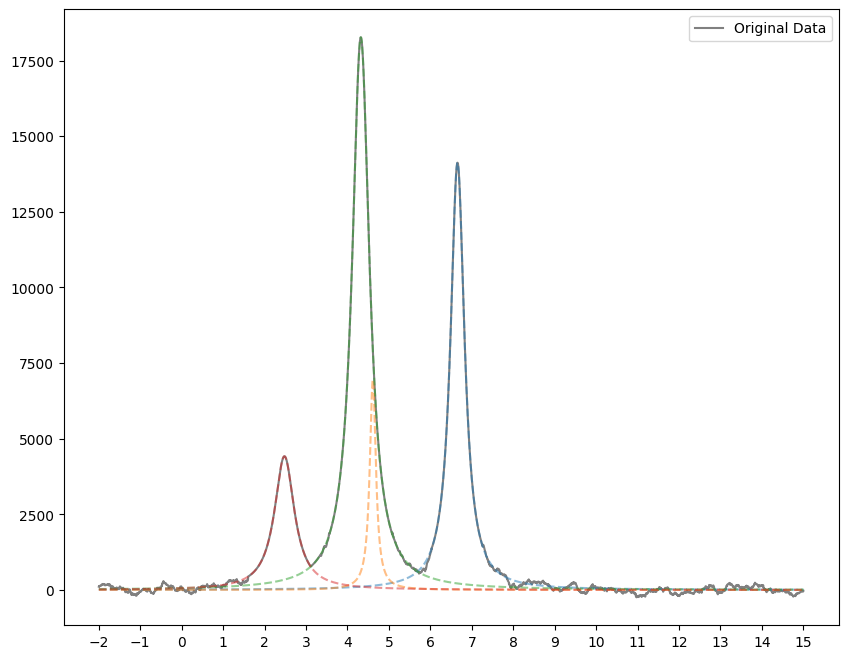

In [31]:
# bring the data back to the cpu
data_train_tensor = data_train_tensor.to("cpu")
data_val_tensor = data_val_tensor.to("cpu")
data_test_tensor = data_test_tensor.to("cpu")

target_train_tensor = target_train_tensor.to("cpu")
target_val_tensor = target_val_tensor.to("cpu")
target_test_tensor = target_test_tensor.to("cpu")

data_train_tensor = data_train_tensor.squeeze(1)
data_val_tensor = data_val_tensor.squeeze(1)
# scale the data back
data_train = data_scaler.inverse_transform(data_train_tensor)
data_val = data_scaler.inverse_transform(data_val_tensor)
target_train = target_scaler.inverse_transform(target_train_tensor)


print(f'data_train: {data_train.shape}')
print(f'data_val: {data_val.shape}')
print(f'target_train: {target_train.shape}')

print(f'len substrates_list: {len(substrates_list)}')


x0_parms_train, gamma_parms_train, height_parms_train = np.split(target_train, 3, axis=1)
x0_parms_val, gamma_parms_val, height_parms_val = np.split(target_val, 3, axis=1)
x0_parms_test, gamma_parms_test, height_parms_test = np.split(target_test, 3, axis=1)




n = 10
x = x_data[n]
# plot the data
#plt.plot(x, data_train[n, :], '-', label='Original Data')
# for x0, gamma, height in zip(x0_parms_train[n], gamma_parms_train[n], height_parms_train[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)

# plt.plot(x, data_val[n, :], '-', label='Original Data', color='grey')
# for x0, gamma, height in zip(x0_parms_val[n], gamma_parms_val[n], height_parms_val[n]):
#     lorentz = lorentzian(x, x0, gamma, height)
#     plt.plot(x, lorentz, '--', label='Original Peaks', alpha=0.5)   
    
fig = plt.figure(figsize=(10, 8))

plt.plot(x, data_test[n, :], '-', label='Original Data', color='grey')
for x0, gamma, height in zip(x0_parms_test[n], gamma_parms_test[n], height_parms_test[n]):
    lorentz = lorentzian(x, x0, gamma, height)
    plt.plot(x, lorentz, '--', alpha=0.5)

plt.xticks(np.arange(-2, 16, 1))
plt.legend()
plt.show()

# Validate on real Data

In [32]:
# # Use a dataframe to collect general evaluation results
# results = pd.DataFrame()

# # We will reuse this function. Hence we copy it to mads_dl.py
# def add_regression_eval(results, algorithm, y_train, y_train_pred, y_test, y_test_pred, num_params):
#     '''
#     Create a table with evaluation results
#     of a regression experiment
#     '''
#     for dataset, actual, predicted in zip(("train", "test"), (y_train, y_test), (y_train_pred, y_test_pred)):
#         mse=mean_squared_error(actual, predicted)
#         results= pd.concat([results, pd.DataFrame([{
#             "algorithm": algorithm, 
#             "dataset": dataset,
#             "MSE": mse,
#             "RMSE": math.sqrt(mse),
#             "MAE": mean_absolute_error(actual, predicted),
#             "MAPE": mean_absolute_percentage_error(actual, predicted)*100, # implemented is relative to 1 not to 100
#             "params": num_params
#         }])], ignore_index=True)   
#     return results


# Test on Data

(1, 3000)


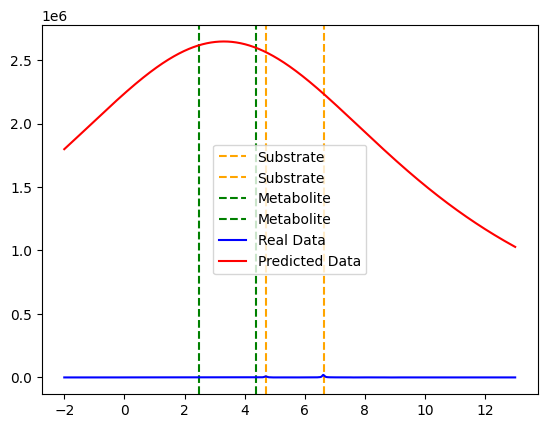

(1, 3000)


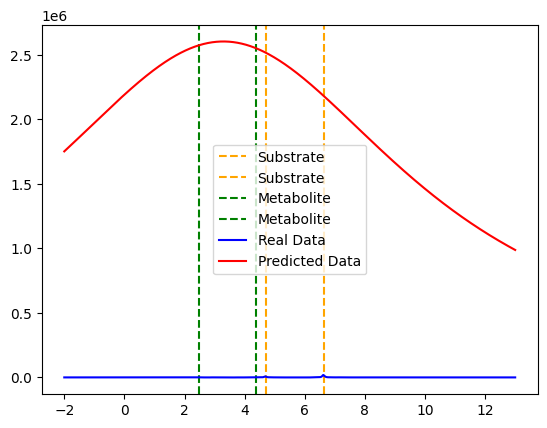

(1, 3000)


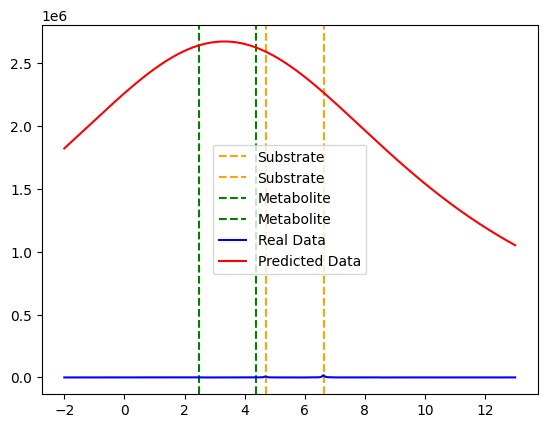

(1, 3000)


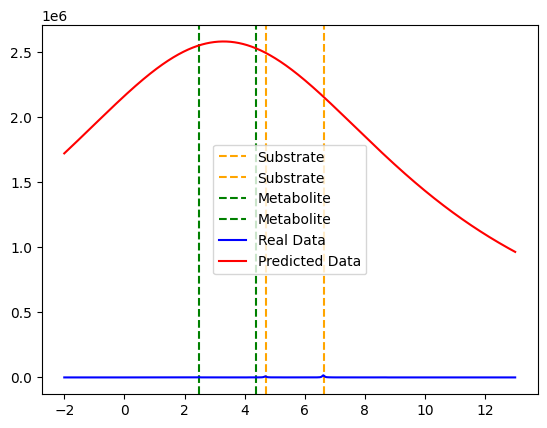

(1, 3000)


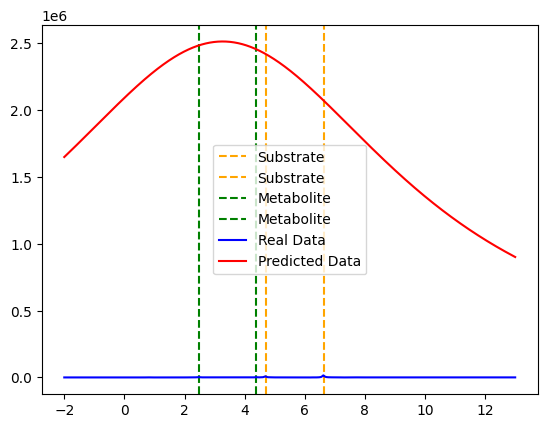

(1, 3000)


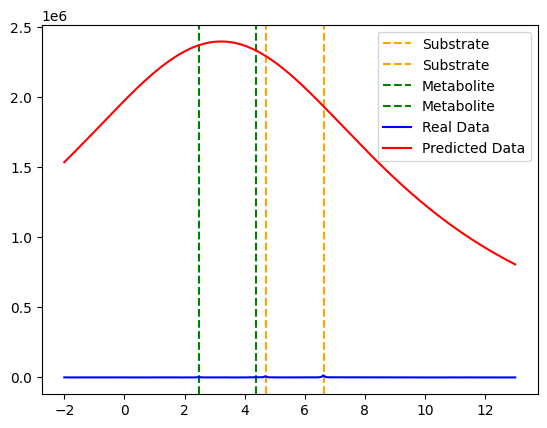

(1, 3000)


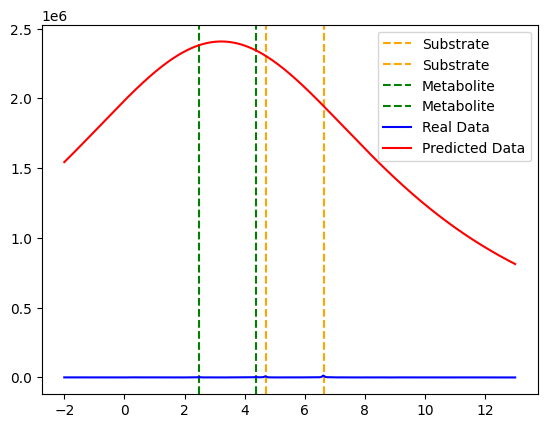

(1, 3000)


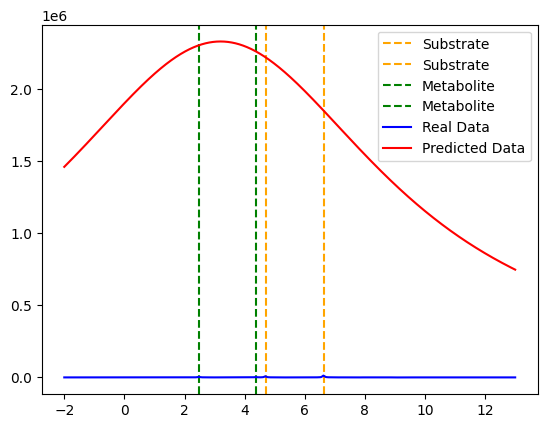

(1, 3000)


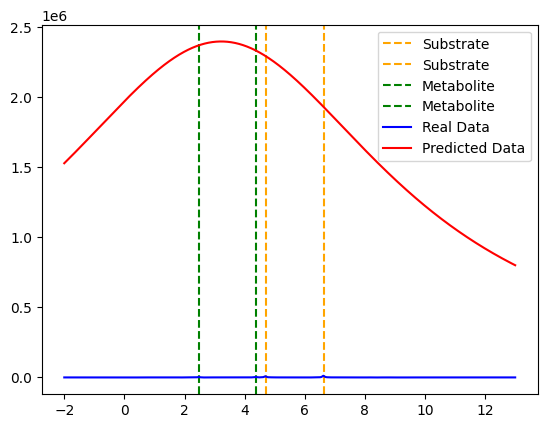

In [33]:
df = pd.read_csv(path_list[0]) 

for i in range(1, 10):
    # fill the data
    df_fill = fill_df(df.iloc[:, [0, i]])

    # interpolate the data
    df_interpolated = interpolate_to_shape(df_fill.iloc[:, 0], df_fill.iloc[:, 1], spectrum_lenth=3000)
    #display(df_interpolated)
    x_real = df_interpolated.loc[:, 'x']
    y_real = df_interpolated.loc[:, 'y']

    # scale the data
    y_real_sc = data_scaler.transform(y_real.values.reshape(1, -1))
    print(y_real_sc.shape)

    # convert to tensor
    y_real_tensor = torch.tensor(y_real_sc, dtype=torch.float32)

    # predict the data
    target_real_pred = model.predict(y_real_tensor)

    # bring the data back to the cpu
    target_real_pred = target_real_pred.cpu().detach().numpy()

    # rescale the data
    target_real_pred_rescaled = target_scaler.inverse_transform(target_real_pred)

    # reshape the data
    target_real_pred = target_real_pred_rescaled.reshape(target_real_pred_rescaled.shape[0], -1)

    x0_parms_real, gamma_parms_real, height_parms_real = np.split(target_real_pred, 3, axis=1)

    # calcualte the mse
    #mse = calculate_mse_of_real_data(df, model, random=False, i=i)
    #print(mse)
    
    # Put the Lorenz functions in a Dataframe
    lorentz_list = []
    lorentz_df = pd.DataFrame({'x': x_real})  # Initialize DataFrame with x_real

    for i, (x0, gamma, height) in enumerate(zip(x0_parms_real[0], gamma_parms_real[0], height_parms_real[0])):
        lorentz = lorentzian(x_real, x0, gamma, height)
        column_name = f'lorentz_{i}'  # Dynamically generate a unique column name
        lorentz_df = pd.concat([lorentz_df, pd.DataFrame({column_name: lorentz})], axis=1)

    # add another column which takes the np.maximum of the columns
    lorentz_df['max'] = lorentz_df.iloc[:, 1:].max(axis=1)
    #display(lorentz_df)
    


    for subs in substrates:
        plt.axvline(x=subs, color='orange', linestyle='--', label='Substrate')

    for metab in metabolites:
        plt.axvline(x=metab, color='green', linestyle='--', label='Metabolite')

    plt.plot(x_real, y_real, label='Real Data', color='blue')
    plt.plot(x_real, lorentz_df['max'], label='Predicted Data', color='red')


    plt.legend()
    plt.show()

In [34]:
substrates, metabolites

([6.653, 4.7], [4.368, 2.474])